In [ ]:
!python --version

Python 3.11.11


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
from sklearn.feature_selection import f_classif

In [ ]:
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Matplotlib version:', mpl.__version__)
print('Seaborn version:', sns.__version__)

Numpy version: 1.26.4
Pandas version: 2.2.2
Matplotlib version: 3.10.0
Seaborn version: 0.13.2


# Credit Card Default: Data Exploration and Cleaning

## Business Problem Overview

Our client, a credit card company, has provided a dataset containing demographic and financial data from the past 6 months for 30,000 account holders. Each row in the dataset corresponds to a credit account, with a label indicating whether the account holder defaulted (failed to make the minimum payment) in the month following the 6 months.

The goal is to develop a predictive model to forecast whether an account will default in the next month based on demographic and financial data.

## Data Exploration and Cleaning

The dataset consists of 25 columns, encompassing demographic and financial details, such as credit limits, payment histories, and bill/payment amounts, with the target variable indicating whether the account defaulted. The columns are as follows:

- **`client_id`**: Unique identifier for each account.
- **`credit_limit_ntd`**: Credit limit in New Taiwan Dollars (NTD), including individual and supplementary credit.
- **`gender`**: Gender of the account holder (For ethical reasons, gender will not be used in decision-making):
  - `1` = male
  - `2` = female
- **`education_level`**: Account holder's education level:
  - `1` = graduate school
  - `2` = university
  - `3` = high school
  - `4` = other
- **`marital_status`**: Account holder's marital status:
  - `1` = married
  - `2` = single
  - `3` = other
- **`age_years`**: Account holder's age (in years).
- **`payment_status_september` to `payment_status_april`**: Payment statuses for each month from April to September:
  - `-1` = paid duly
  - `1` = 1-month delay
  - `2` = 2-month delay
  - ... up to `9` = 9 months or more delay
- **`bill_amount_september_ntd` to `bill_amount_april_ntd`**: Monthly billing amounts in NTD.
- **`payment_amount_september_ntd` to `payment_amount_april_ntd`**: Monthly payment amounts in NTD.
- **`default_next_month`**: Target variable indicating whether the account defaulted:
  - `1` = defaulted
  - `0` = did not default

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/My Drive/credit-card-default/default_of_credit_card_clients.csv'
data_raw = pd.read_csv(file_path)

In [ ]:
data_raw.head()

,client_id,credit_limit_ntd,gender,education_level,marital_status,age_years,payment_status_september,payment_status_august,payment_status_july,payment_status_june,...,bill_amount_june_ntd,bill_amount_may_ntd,bill_amount_april_ntd,payment_amount_september_ntd,payment_amount_august_ntd,payment_amount_july_ntd,payment_amount_june_ntd,payment_amount_may_ntd,payment_amount_april_ntd,default_next_month
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   client_id                     30000 non-null  object
 1   credit_limit_ntd              30000 non-null  int64 
 2   gender                        30000 non-null  int64 
 3   education_level               30000 non-null  int64 
 4   marital_status                30000 non-null  int64 
 5   age_years                     30000 non-null  int64 
 6   payment_status_september      30000 non-null  object
 7   payment_status_august         30000 non-null  int64 
 8   payment_status_july           30000 non-null  int64 
 9   payment_status_june           30000 non-null  int64 
 10  payment_status_may            30000 non-null  int64 
 11  payment_status_april          30000 non-null  int64 
 12  bill_amount_september_ntd     30000 non-null  int64 
 13  bill_amount_augu

Each row shows 30,000 non-null values, but missing data may be hidden if represented by a fill value.

Most columns are `int64`, indicating an integer data type, except for `client_id` and `payment_status_september`. The `client_id` column contains account IDs as strings, which is expected. However, according to the data dictionary, `payment_status_september` should contain integers like the other payment status features. Let's take a closer look at this column.

In [ ]:
data_raw['payment_status_september'].value_counts()

,count
payment_status_september,
0,13402
-1,5047
1,3261
Not available,3021
-2,2476
2,2378
3,292
4,63
5,23


The output shows two undocumented values, `0` and `-2`, and explains why `payment_status_september` was imported as an `object` rather than `int64`. The column contains the string `Not available`, indicating missing data.

In [ ]:
valid_status_mask = data_raw['payment_status_september'] != 'Not available'
data_no_missing = data_raw.loc[valid_status_mask, :].copy()
data_no_missing.shape

(26979, 25)

In [ ]:
data_no_missing['payment_status_september'] = data_no_missing['payment_status_september'].astype(int)
data_no_missing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26979 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   client_id                     26979 non-null  object
 1   credit_limit_ntd              26979 non-null  int64 
 2   gender                        26979 non-null  int64 
 3   education_level               26979 non-null  int64 
 4   marital_status                26979 non-null  int64 
 5   age_years                     26979 non-null  int64 
 6   payment_status_september      26979 non-null  int64 
 7   payment_status_august         26979 non-null  int64 
 8   payment_status_july           26979 non-null  int64 
 9   payment_status_june           26979 non-null  int64 
 10  payment_status_may            26979 non-null  int64 
 11  payment_status_april          26979 non-null  int64 
 12  bill_amount_september_ntd     26979 non-null  int64 
 13  bill_amount_august_nt

We also noticed undocumented values in `payment_status_september`. After consulting with our business partner, we clarified the following:

- `-2` = Zero balance at the start of the month, with no credit usage.
- `0` = Minimum payment made, with a balance carried to the next month.

In [ ]:
data_no_missing['client_id'].nunique()

26704

In [ ]:
data_no_missing.shape

(26979, 25)

The dataset contains 26,979 rows and 26,704 unique entries, indicating duplicate IDs. We need to assess whether a single ID is duplicated multiple times or if several IDs are repeated.

In [ ]:
id_counts = data_no_missing['client_id'].value_counts()
id_counts.head()

,count
client_id,
d5aeb496-64e5,2
443324fb-5cfc,2
f20d8a3d-d047,2
693a0664-bde6,2
8567249b-827e,2


In [ ]:
id_counts.value_counts()

,count
count,
1,26429
2,275


275 IDs are duplicated twice, with no ID occurring more than twice.

In [ ]:
duplicate_ids_mask = id_counts == 2 # Boolean mask for locating duplicate IDs.
duplicate_ids_mask.head()

,count
client_id,
d5aeb496-64e5,True
443324fb-5cfc,True
f20d8a3d-d047,True
693a0664-bde6,True
8567249b-827e,True


In [ ]:
duplicate_ids_mask.tail()

,count
client_id,
0671c9ee-650e,False
08c5ae4a-730a,False
1ef33467-7463,False
81301c65-31d4,False
15d69f9f-5ad3,False


In [ ]:
id_counts[duplicate_ids_mask] # id_counts[id_counts == 2]

,count
client_id,
d5aeb496-64e5,2
443324fb-5cfc,2
f20d8a3d-d047,2
693a0664-bde6,2
8567249b-827e,2
...,...
47d9ee33-0df0,2
26bde6da-f148,2
f63d8fbe-d79e,2


In [ ]:
duplicate_ids = id_counts.index[duplicate_ids_mask] # The IDs themselves are contained as the index of the `id_counts` Series.
duplicate_ids

Index(['d5aeb496-64e5', '443324fb-5cfc', 'f20d8a3d-d047', '693a0664-bde6',
       '8567249b-827e', '590a776e-5049', '2189fc56-f82a', '0913d642-c5d4',
       'af1e3f79-f628', '297edb0f-3bb1',
       ...
       '4dc45e9a-27bd', 'c9826d63-f7d3', 'fc73f07e-eb96', '5f483bdb-3aaf',
       '93b2c5f7-acea', '47d9ee33-0df0', '26bde6da-f148', 'f63d8fbe-d79e',
       'dda76366-a407', 'c3ddce11-35e2'],
      dtype='object', name='client_id', length=275)

In [ ]:
duplicate_ids = list(duplicate_ids)
len(duplicate_ids)

275

We're ready to examine the duplicate IDs and compare their feature values to identify differences.

In [ ]:
# Use the first three duplicate IDs to create a Boolean mask for matching rows.
# The .isin() method checks whether each `client_id` is in the list and returns True for matches.
# The .loc[] method filters the DataFrame based on this mask, selecting all columns (:).
# The result displays all columns for rows with the first three duplicate IDs.
data_no_missing.loc[data_no_missing['client_id'].isin(duplicate_ids[0:3]), :]

,client_id,credit_limit_ntd,gender,education_level,marital_status,age_years,payment_status_september,payment_status_august,payment_status_july,payment_status_june,...,bill_amount_june_ntd,bill_amount_may_ntd,bill_amount_april_ntd,payment_amount_september_ntd,payment_amount_august_ntd,payment_amount_july_ntd,payment_amount_june_ntd,payment_amount_may_ntd,payment_amount_april_ntd,default_next_month
541,d5aeb496-64e5,150000,2,1,2,28,1,-2,-2,-2,...,0,0,318,0,0,0,0,318,0,0
641,d5aeb496-64e5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19575,443324fb-5cfc,210000,2,1,1,31,0,0,0,0,...,119579,120318,107122,7505,7072,4009,8000,10000,12000,0
19675,443324fb-5cfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27419,f20d8a3d-d047,50000,1,1,1,45,-1,-1,-1,-1,...,390,390,390,390,390,390,390,390,390,1
27519,f20d8a3d-d047,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Each duplicate ID appears to have one row with valid data and another with all zeros. A row consisting entirely of zeros is invalid, as it is unrealistic for someone to have an age, credit limit, and other features all set to zero.

One approach to addressing this issue is identifying rows with all zeros, except for the first column containing the IDs. Removing these invalid entries may also resolve the duplicate ID issue.



In [ ]:
# Boolean mask to identify entries equal to zero in the DataFrame.
# This matrix has the same size as the original DataFrame, with True indicating zero values.
full_zero_mask = data_no_missing == 0
full_zero_mask.head()

,client_id,credit_limit_ntd,gender,education_level,marital_status,age_years,payment_status_september,payment_status_august,payment_status_july,payment_status_june,...,bill_amount_june_ntd,bill_amount_may_ntd,bill_amount_april_ntd,payment_amount_september_ntd,payment_amount_august_ntd,payment_amount_july_ntd,payment_amount_june_ntd,payment_amount_may_ntd,payment_amount_april_ntd,default_next_month
0,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,False,True,True,True,True,False
1,False,False,False,False,False,False,False,False,True,True,...,False,False,False,True,False,False,False,True,False,False
2,False,False,False,False,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
# Create a Boolean Series to identify rows where all values, starting from the second column, are zero.
# This excludes the `client_id` column and checks only the feature and response columns.
# Index `full_zero_mask` using the .iloc method to select all rows (:) and all columns from the second onward (1:).
# Apply the .all() method along the column axis (axis=1) to check if all values in each row are True.
# The result is a Boolean Series with True for rows where all non-ID values are zero.
non_id_zero_mask = full_zero_mask.iloc[:, 1:].all(axis=1)
non_id_zero_mask.head()

,0
0,False
1,False
2,False
3,False
4,False


In [ ]:
sum(non_id_zero_mask)

315

The output shows 315 rows with zeros in all columns except the first. Removing these rows may resolve the 313 duplicate IDs.

In [ ]:
data_no_zeros = data_no_missing.loc[~non_id_zero_mask, :].copy()
data_no_zeros.shape

(26664, 25)

In [ ]:
data_no_zeros['client_id'].nunique()

26664

Duplicates have been removed, with unique IDs matching the row count.

We identified a data quality issue with the account ID metadata. While we were initially informed that each sample corresponded to a unique account, this proved inaccurate. Moving forward, we will disregard the account ID column, as it does not contribute to building a predictive model for credit default.

In [ ]:
data_no_zeros.drop(columns='client_id', inplace=True)
data_no_zeros.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26664 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   credit_limit_ntd              26664 non-null  int64
 1   gender                        26664 non-null  int64
 2   education_level               26664 non-null  int64
 3   marital_status                26664 non-null  int64
 4   age_years                     26664 non-null  int64
 5   payment_status_september      26664 non-null  int64
 6   payment_status_august         26664 non-null  int64
 7   payment_status_july           26664 non-null  int64
 8   payment_status_june           26664 non-null  int64
 9   payment_status_may            26664 non-null  int64
 10  payment_status_april          26664 non-null  int64
 11  bill_amount_september_ntd     26664 non-null  int64
 12  bill_amount_august_ntd        26664 non-null  int64
 13  bill_amount_july_ntd          26664 

Since `credit_limit_ntd` and `age_years` are continuous numerical features, we'll use histograms to visualize their distributions.

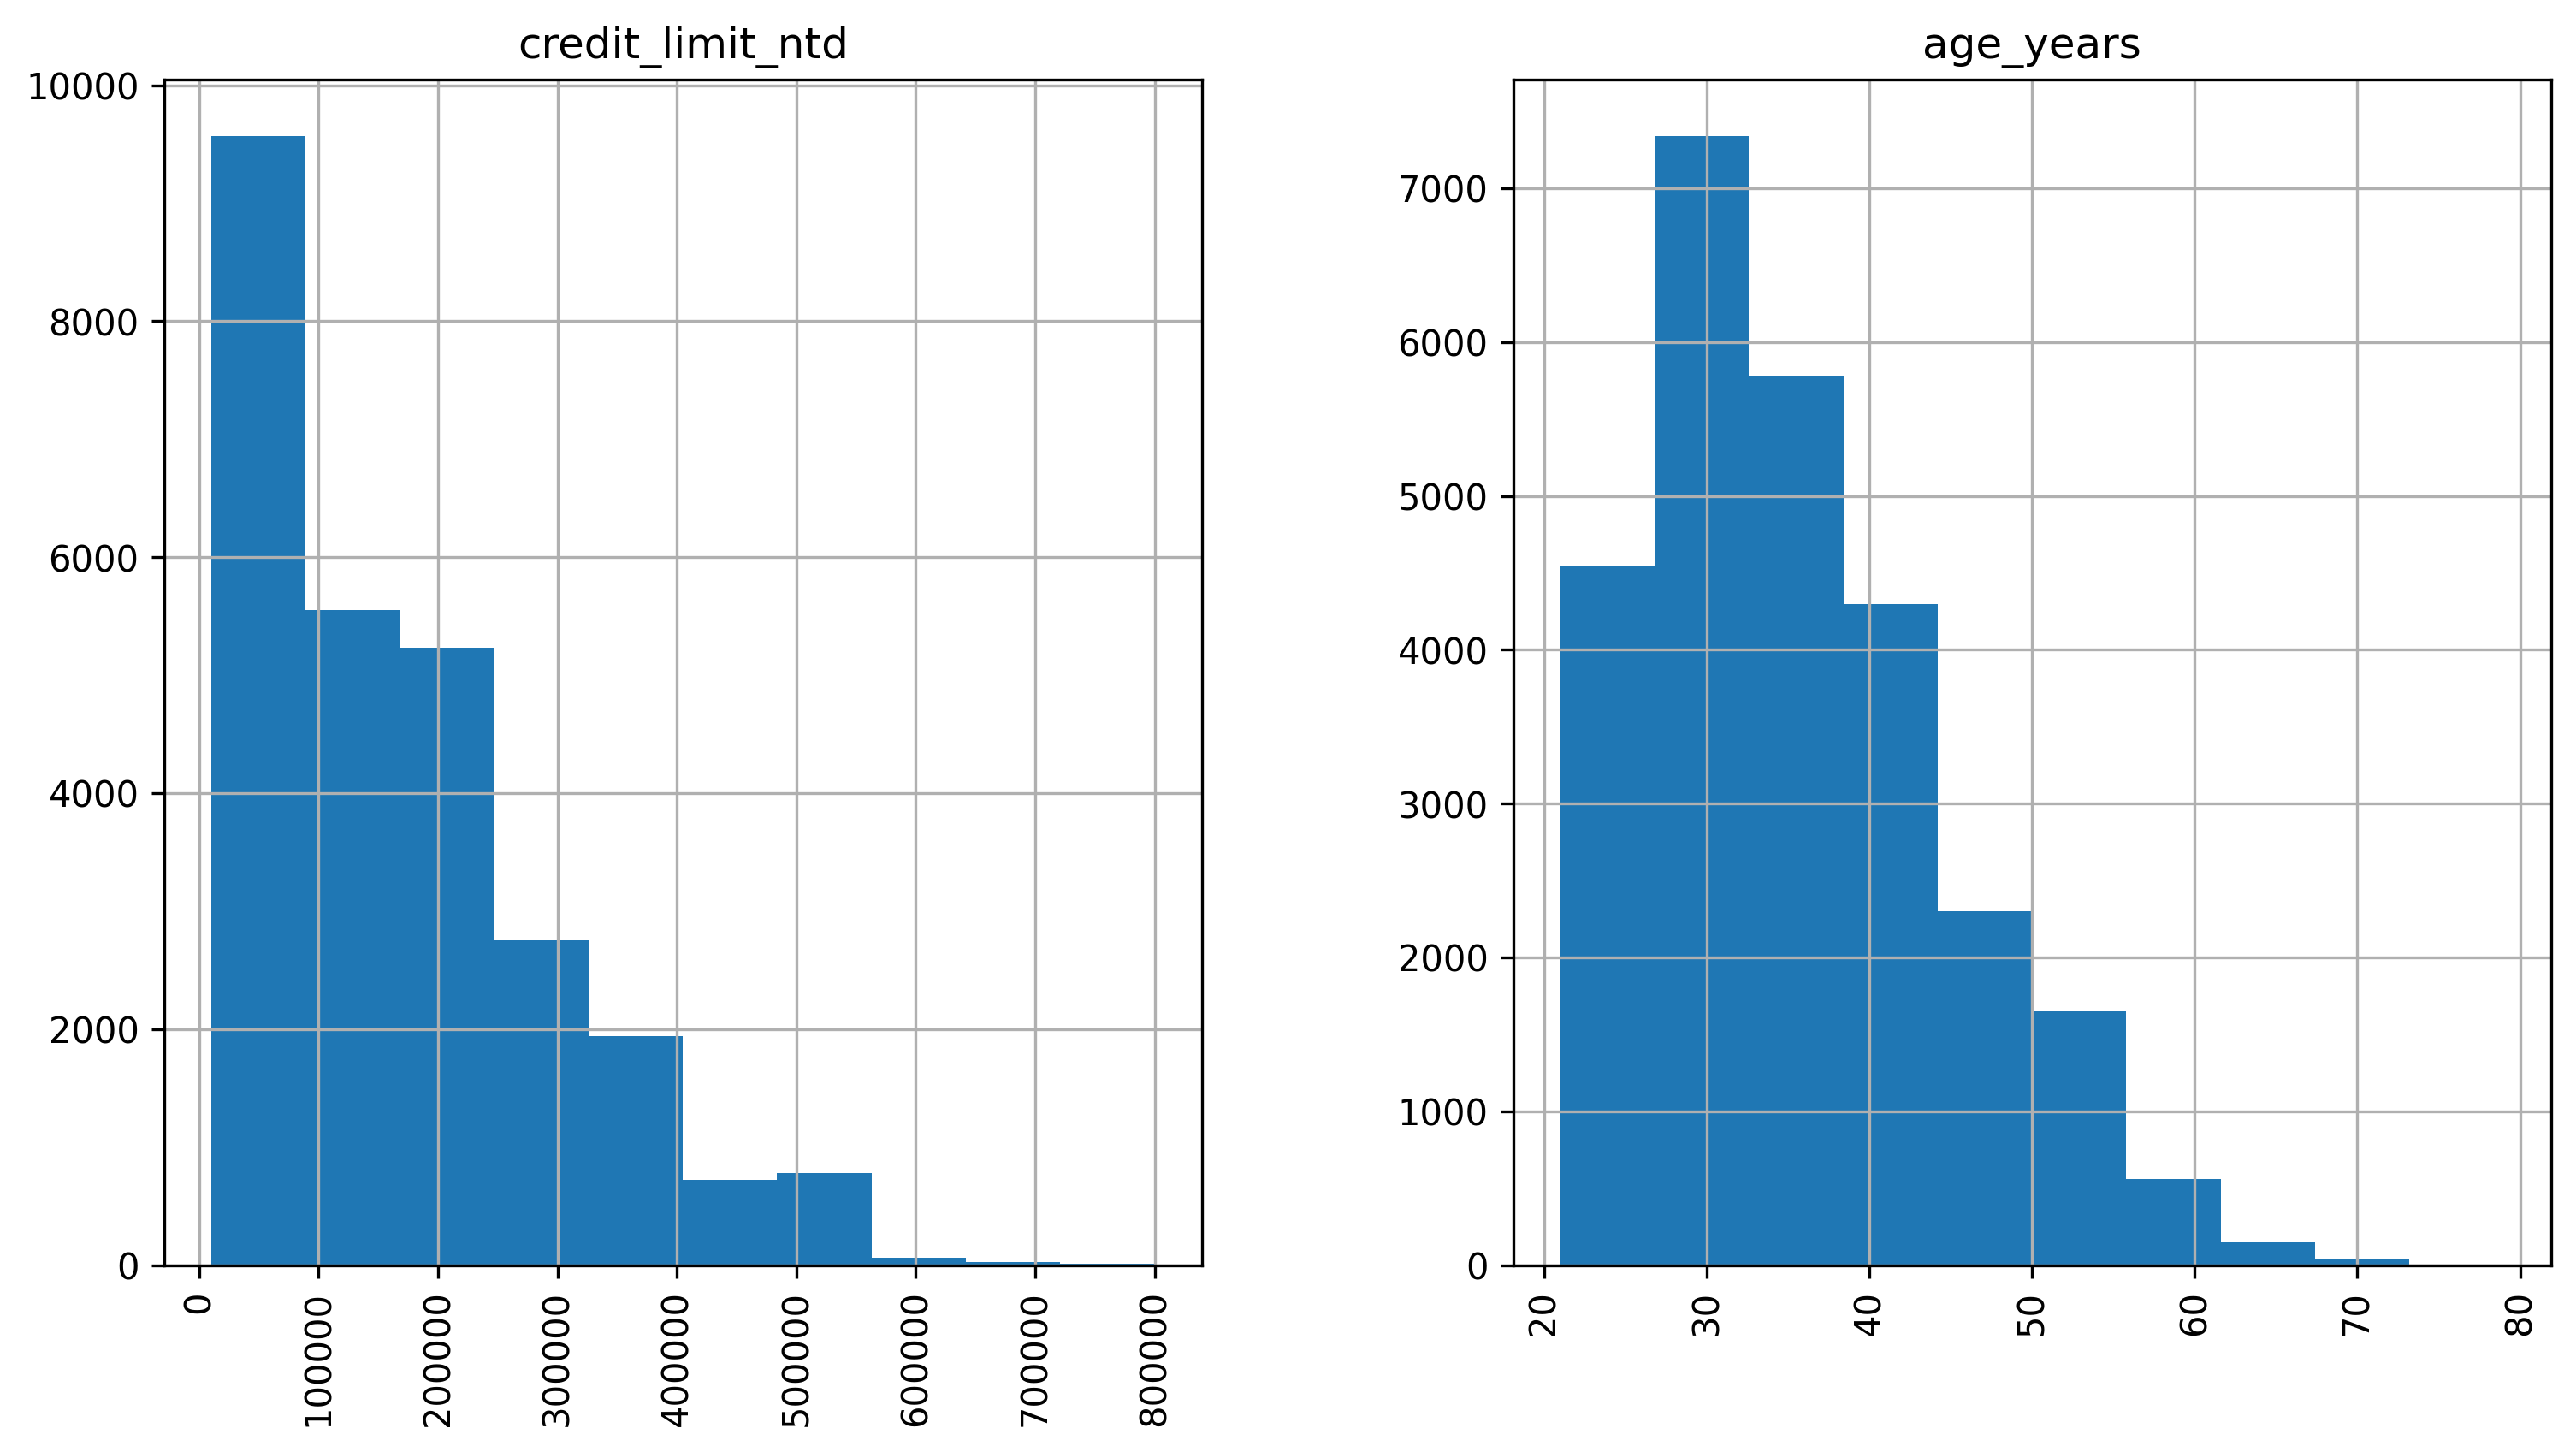

In [ ]:
data_no_zeros[['credit_limit_ntd', 'age_years']].hist(xrot=90, figsize=(12, 6));

In [ ]:
data_no_zeros[['credit_limit_ntd', 'age_years']].describe()

,credit_limit_ntd,age_years
count,26664.000000,26664.000000
mean,167919.054905,35.505213
std,129839.453081,9.227442
min,10000.000000,21.000000
25%,50000.000000,28.000000
50%,140000.000000,34.000000
75%,240000.000000,41.000000
max,800000.000000,79.000000


The dataset includes 26,664 entries for `credit_limit_ntd` and `age_years`.

- `credit_limit_ntd`: The average credit limit is 167,919 NTD, with a standard deviation of 129,839 NTD. Limits range from 10,000 NTD to 800,000 NTD, with 50% of accounts having a limit below 140,000 NTD.
- `age_years`: The average age is 35.5 years, with a standard deviation of 9.23 years. Ages range from 21 to 79 years, with half of the account holders below 34.

Value counts are helpful for categorical features due to their limited unique values.

In [ ]:
data_no_zeros['education_level'].value_counts()

,count
education_level,
2,12458
1,9412
3,4380
5,245
4,115
6,43
0,11


We see undocumented education levels `0`, `5`, and `6`, which are not in the data dictionary. Our business partner is unsure about them, so we will group them with the `other` category due to their low prevalence.

In [ ]:
data_no_zeros['education_level'] = data_no_zeros['education_level'].replace(to_replace=[0, 5, 6], value=4)
data_no_zeros['education_level'].value_counts()

,count
education_level,
2,12458
1,9412
3,4380
4,414


In [ ]:
data_no_zeros['marital_status'].value_counts()

,count
marital_status,
2,14158
1,12172
3,286
0,48


The issue is similar to the `education_level` feature: the value `0` is undocumented in the data dictionary (`1` = married; `2` = single; `3` = other). We'll group it with the `other` category.

In [ ]:
data_no_zeros['marital_status'] = data_no_zeros['marital_status'].replace(to_replace=[0], value=3)
data_no_zeros['marital_status'].value_counts()

,count
marital_status,
2,14158
1,12172
3,334


The `default_next_month` column is binary (`1` = defaulted, `0` = did not default). Calculating the mean provides the proportion of defaults within each education level group.

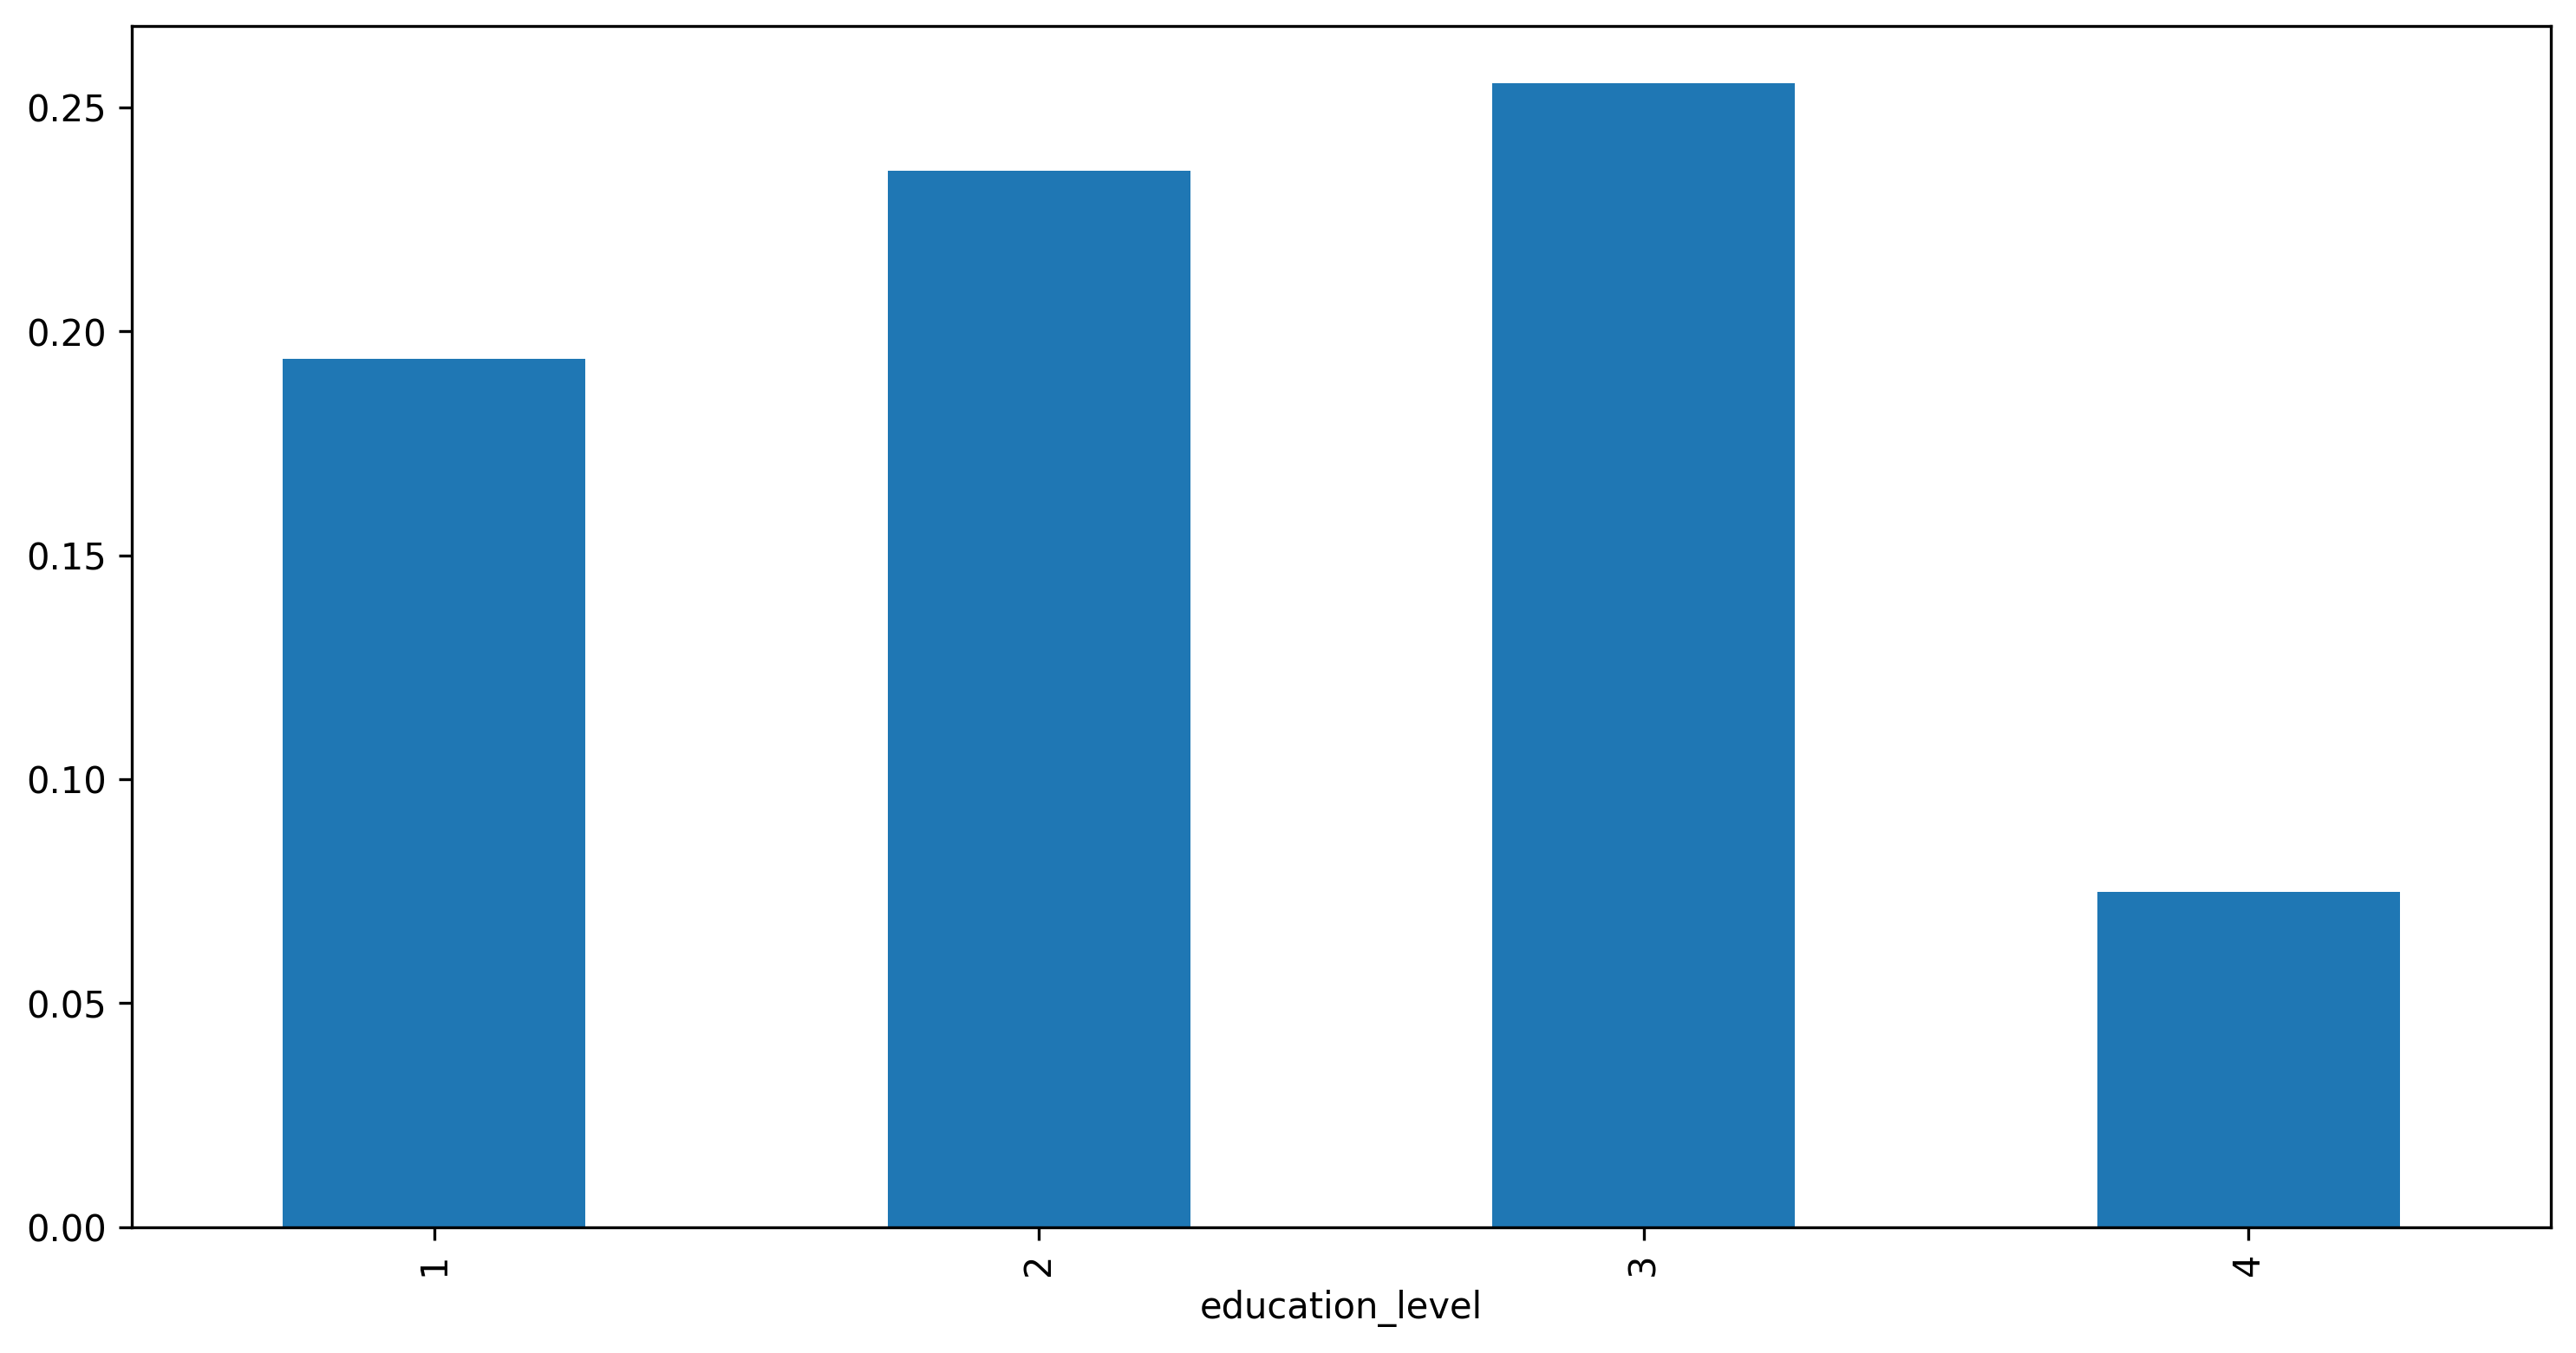

In [ ]:
data_no_zeros.groupby('education_level').agg({'default_next_month': 'mean'}).plot.bar(legend=False, figsize=(12, 6));

A straight-line fit likely won't capture the data well. We could use a more complex model like a decision tree or random forest for non-linear effects or apply alternative encodings for a simpler model like logistic regression. One-hot encoding converts categorical features with text labels into numerical features suitable for mathematical models.

Let's revisit the education_level feature before it was encoded as an ordinal. According to the data dictionary, `1` = graduate school, `2` = university, `3` = high school, and `4` = other. We want to recreate the column using these string labels instead of numbers.

In [ ]:
data_no_zeros['education_cat'] = 'none' # We could have skipped assigning the new column with `none.`
data_no_zeros[['education_level', 'education_cat']].head(10)

,education_level,education_cat
0,2,none
1,2,none
2,2,none
3,2,none
4,2,none
5,1,none
6,1,none
7,2,none
8,3,none
9,3,none


In [ ]:
cat_mapping = {
    1: "graduate school",
    2: "university",
    3: "high school",
    4: "other"
    }
data_no_zeros['education_cat'] = data_no_zeros['education_level'].map(cat_mapping)
data_no_zeros[['education_level', 'education_cat']].head(10)

,education_level,education_cat
0,2,university
1,2,university
2,2,university
3,2,university
4,2,university
5,1,graduate school
6,1,graduate school
7,2,university
8,3,high school
9,3,high school


In [ ]:
education_cat_encoded = pd.get_dummies(data_no_zeros['education_cat'])
education_cat_encoded.head(10)

,graduate school,high school,other,university
0,False,False,False,True
1,False,False,False,True
2,False,False,False,True
3,False,False,False,True
4,False,False,False,True
5,True,False,False,False
6,True,False,False,False
7,False,False,False,True
8,False,True,False,False
9,False,True,False,False


In [ ]:
data_with_education_encoded = pd.concat([data_no_zeros, education_cat_encoded], axis=1)
data_with_education_encoded[['education_cat', 'graduate school', 'high school', 'university', 'other']].head(10)

,education_cat,graduate school,high school,university,other
0,university,False,False,True,False
1,university,False,False,True,False
2,university,False,False,True,False
3,university,False,False,True,False
4,university,False,False,True,False
5,graduate school,True,False,False,False
6,graduate school,True,False,False,False
7,university,False,False,True,False
8,high school,False,True,False,False
9,high school,False,True,False,False


In [ ]:
data_with_education_encoded.to_csv('/content/drive/My Drive/credit-card-default/default_credit_card_clients_processed.csv', index=False)

The remaining features to examine are related to financial history. These naturally fall into three groups: the monthly payment statuses over the past six months and the billed and paid amounts for the same period. Let's start with the payment statuses. Breaking them out as a list will make it easier to analyze them together.

In [ ]:
payment_status_features = [
    'payment_status_september',
    'payment_status_august',
    'payment_status_july',
    'payment_status_june',
    'payment_status_may',
    'payment_status_april'
]
data_with_education_encoded[payment_status_features].describe()

,payment_status_september,payment_status_august,payment_status_july,payment_status_june,payment_status_may,payment_status_april
count,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000
mean,-0.017777,-0.133363,-0.167679,-0.225023,-0.269764,-0.293579
std,1.126769,1.198640,1.199165,1.167897,1.131735,1.150229
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


All these features share the same range of values: `-2`, `-1`, `0`, ... `8`. The value `9`, described in the data dictionary as a payment delay of nine months or more, is not observed.

In [ ]:
data_with_education_encoded[payment_status_features[0]].value_counts()

,count
payment_status_september,
0,13087
-1,5047
1,3261
-2,2476
2,2378
3,292
4,63
5,23
8,17


Most values are either `-2`, `-1`, or `0`, corresponding to an account in good standing last month: not used, paid in full, or made at least the minimum payment.

To better control the plot's appearance, we'll specify bin edges by generating 12 numbers to create 11 bins, each centred on a unique value of `payment_status_september`.

In [ ]:
payment_status_bins = np.array(range(-2, 10)) - 0.5
payment_status_bins

array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,
        8.5])

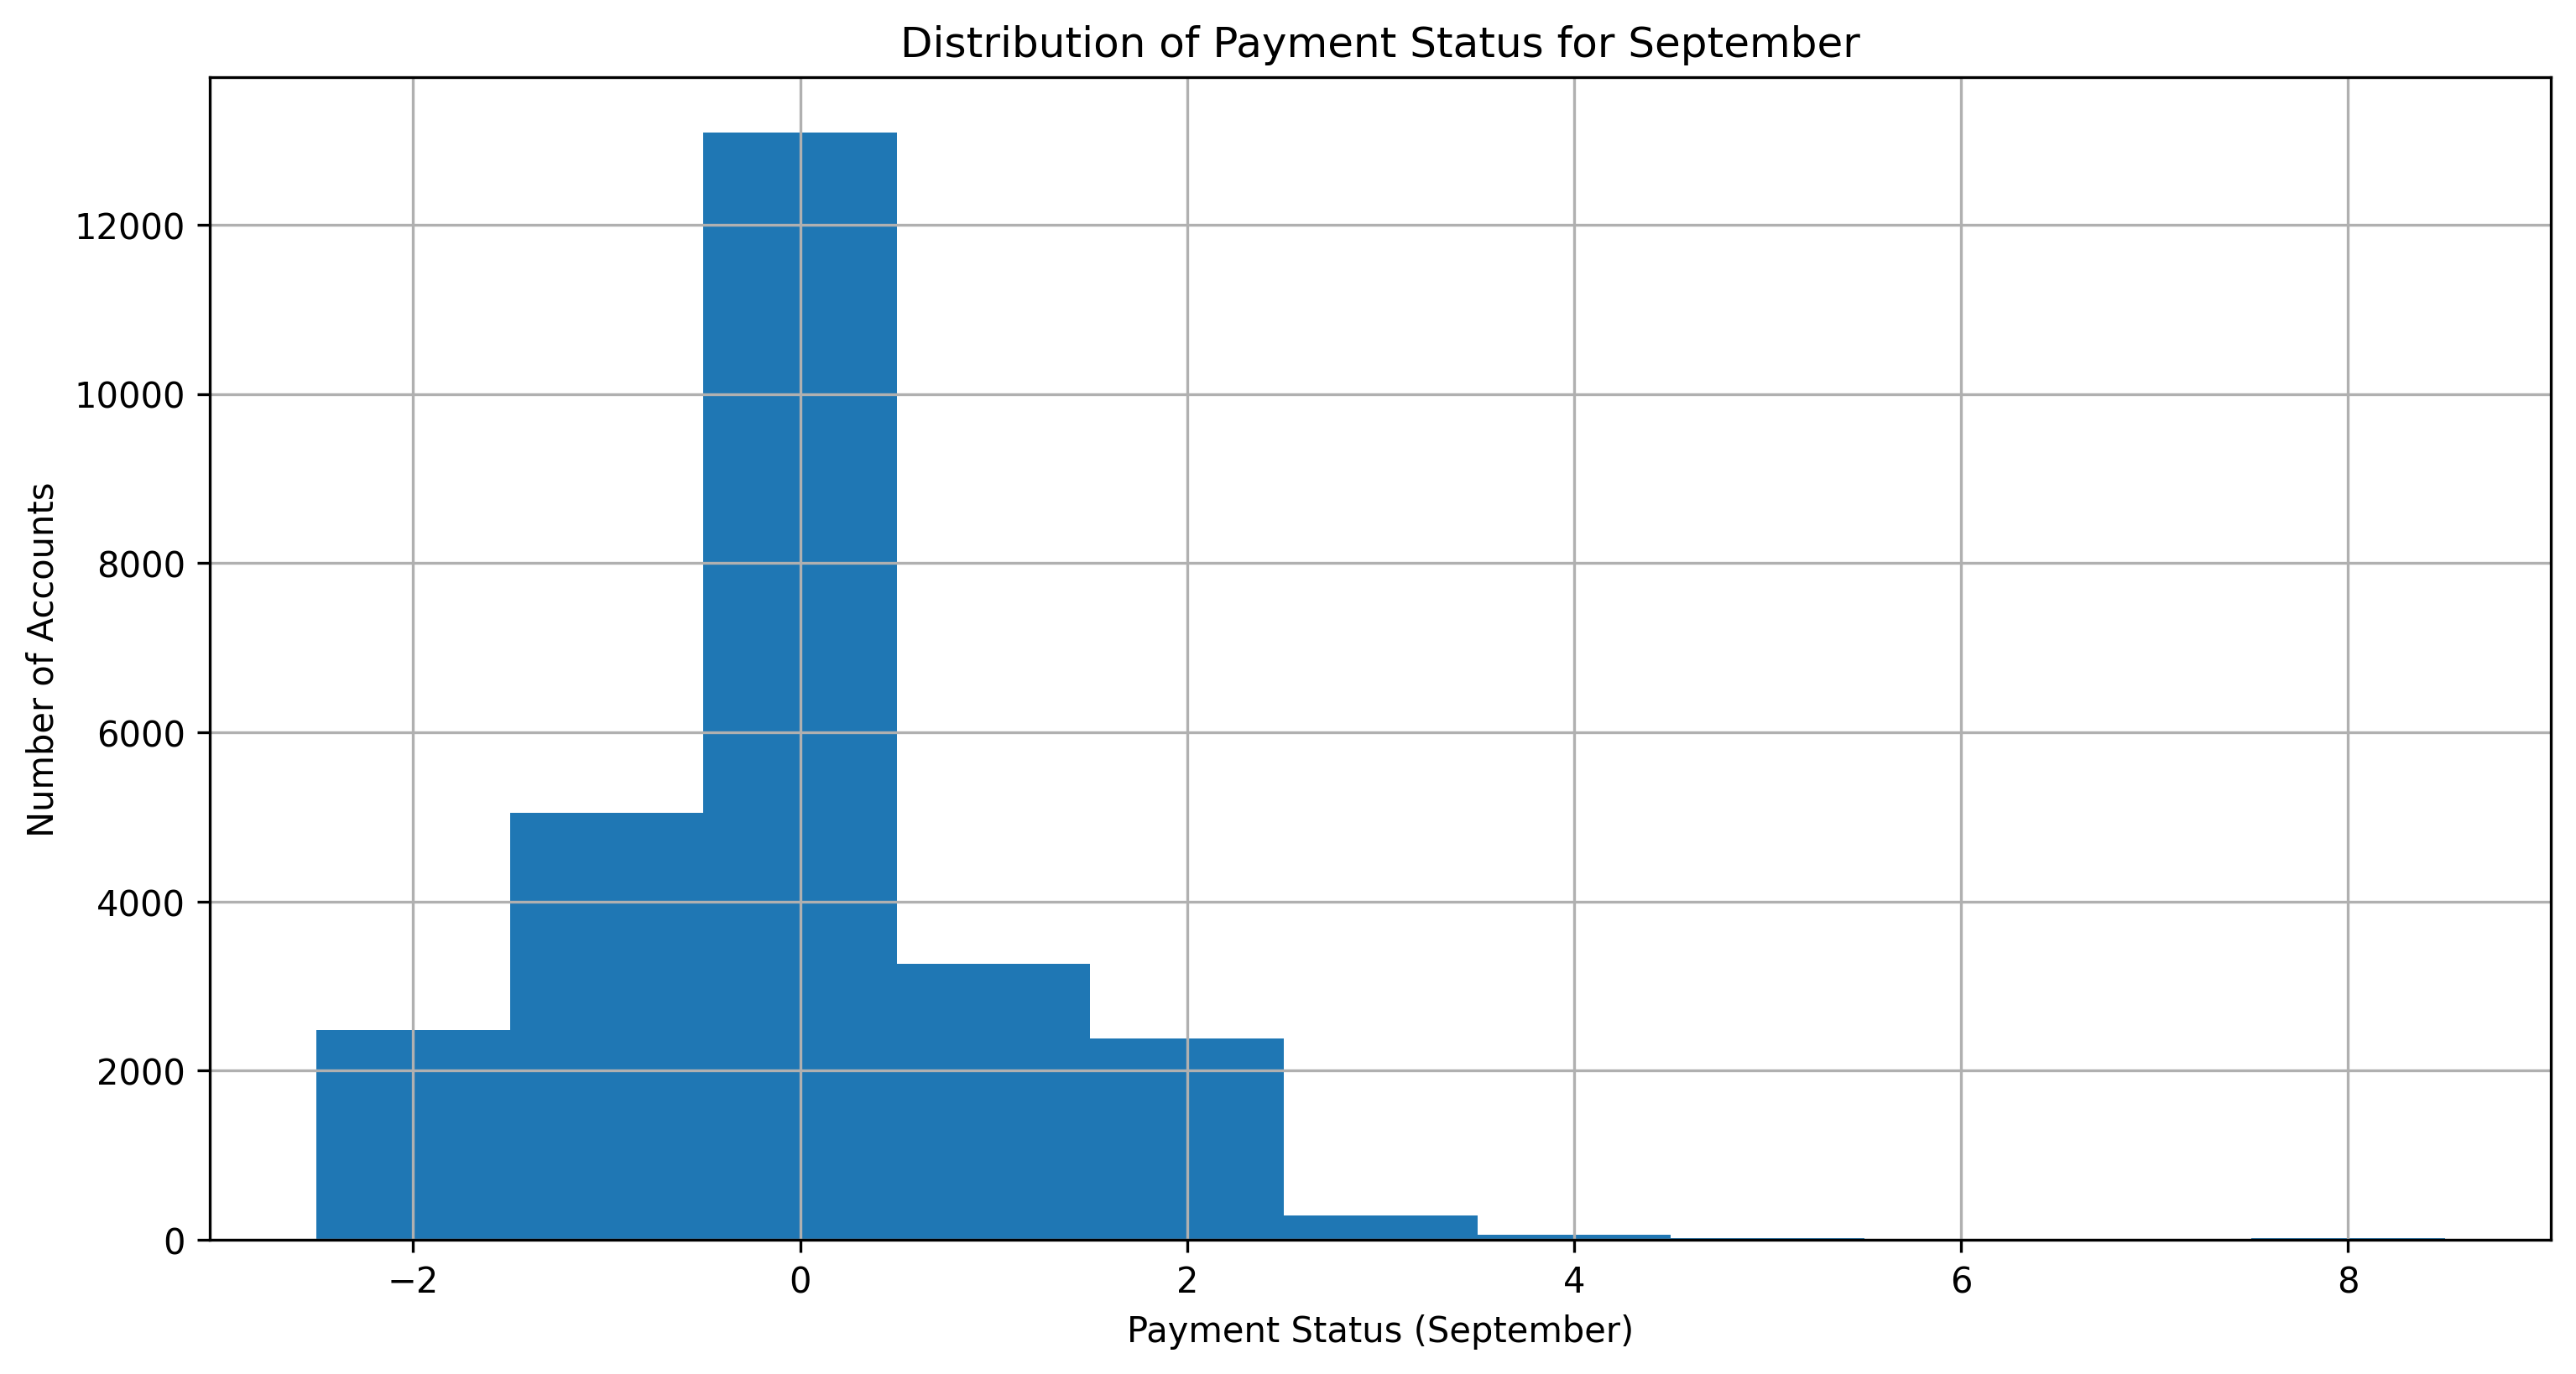

In [ ]:
# The bars are centred over the actual values in the data, and there is 1 bar per unique value.
data_with_education_encoded[payment_status_features[0]].hist(bins=payment_status_bins, figsize=(12, 6))
plt.xlabel('Payment Status (September)')
plt.ylabel('Number of Accounts')
plt.title('Distribution of Payment Status for September');

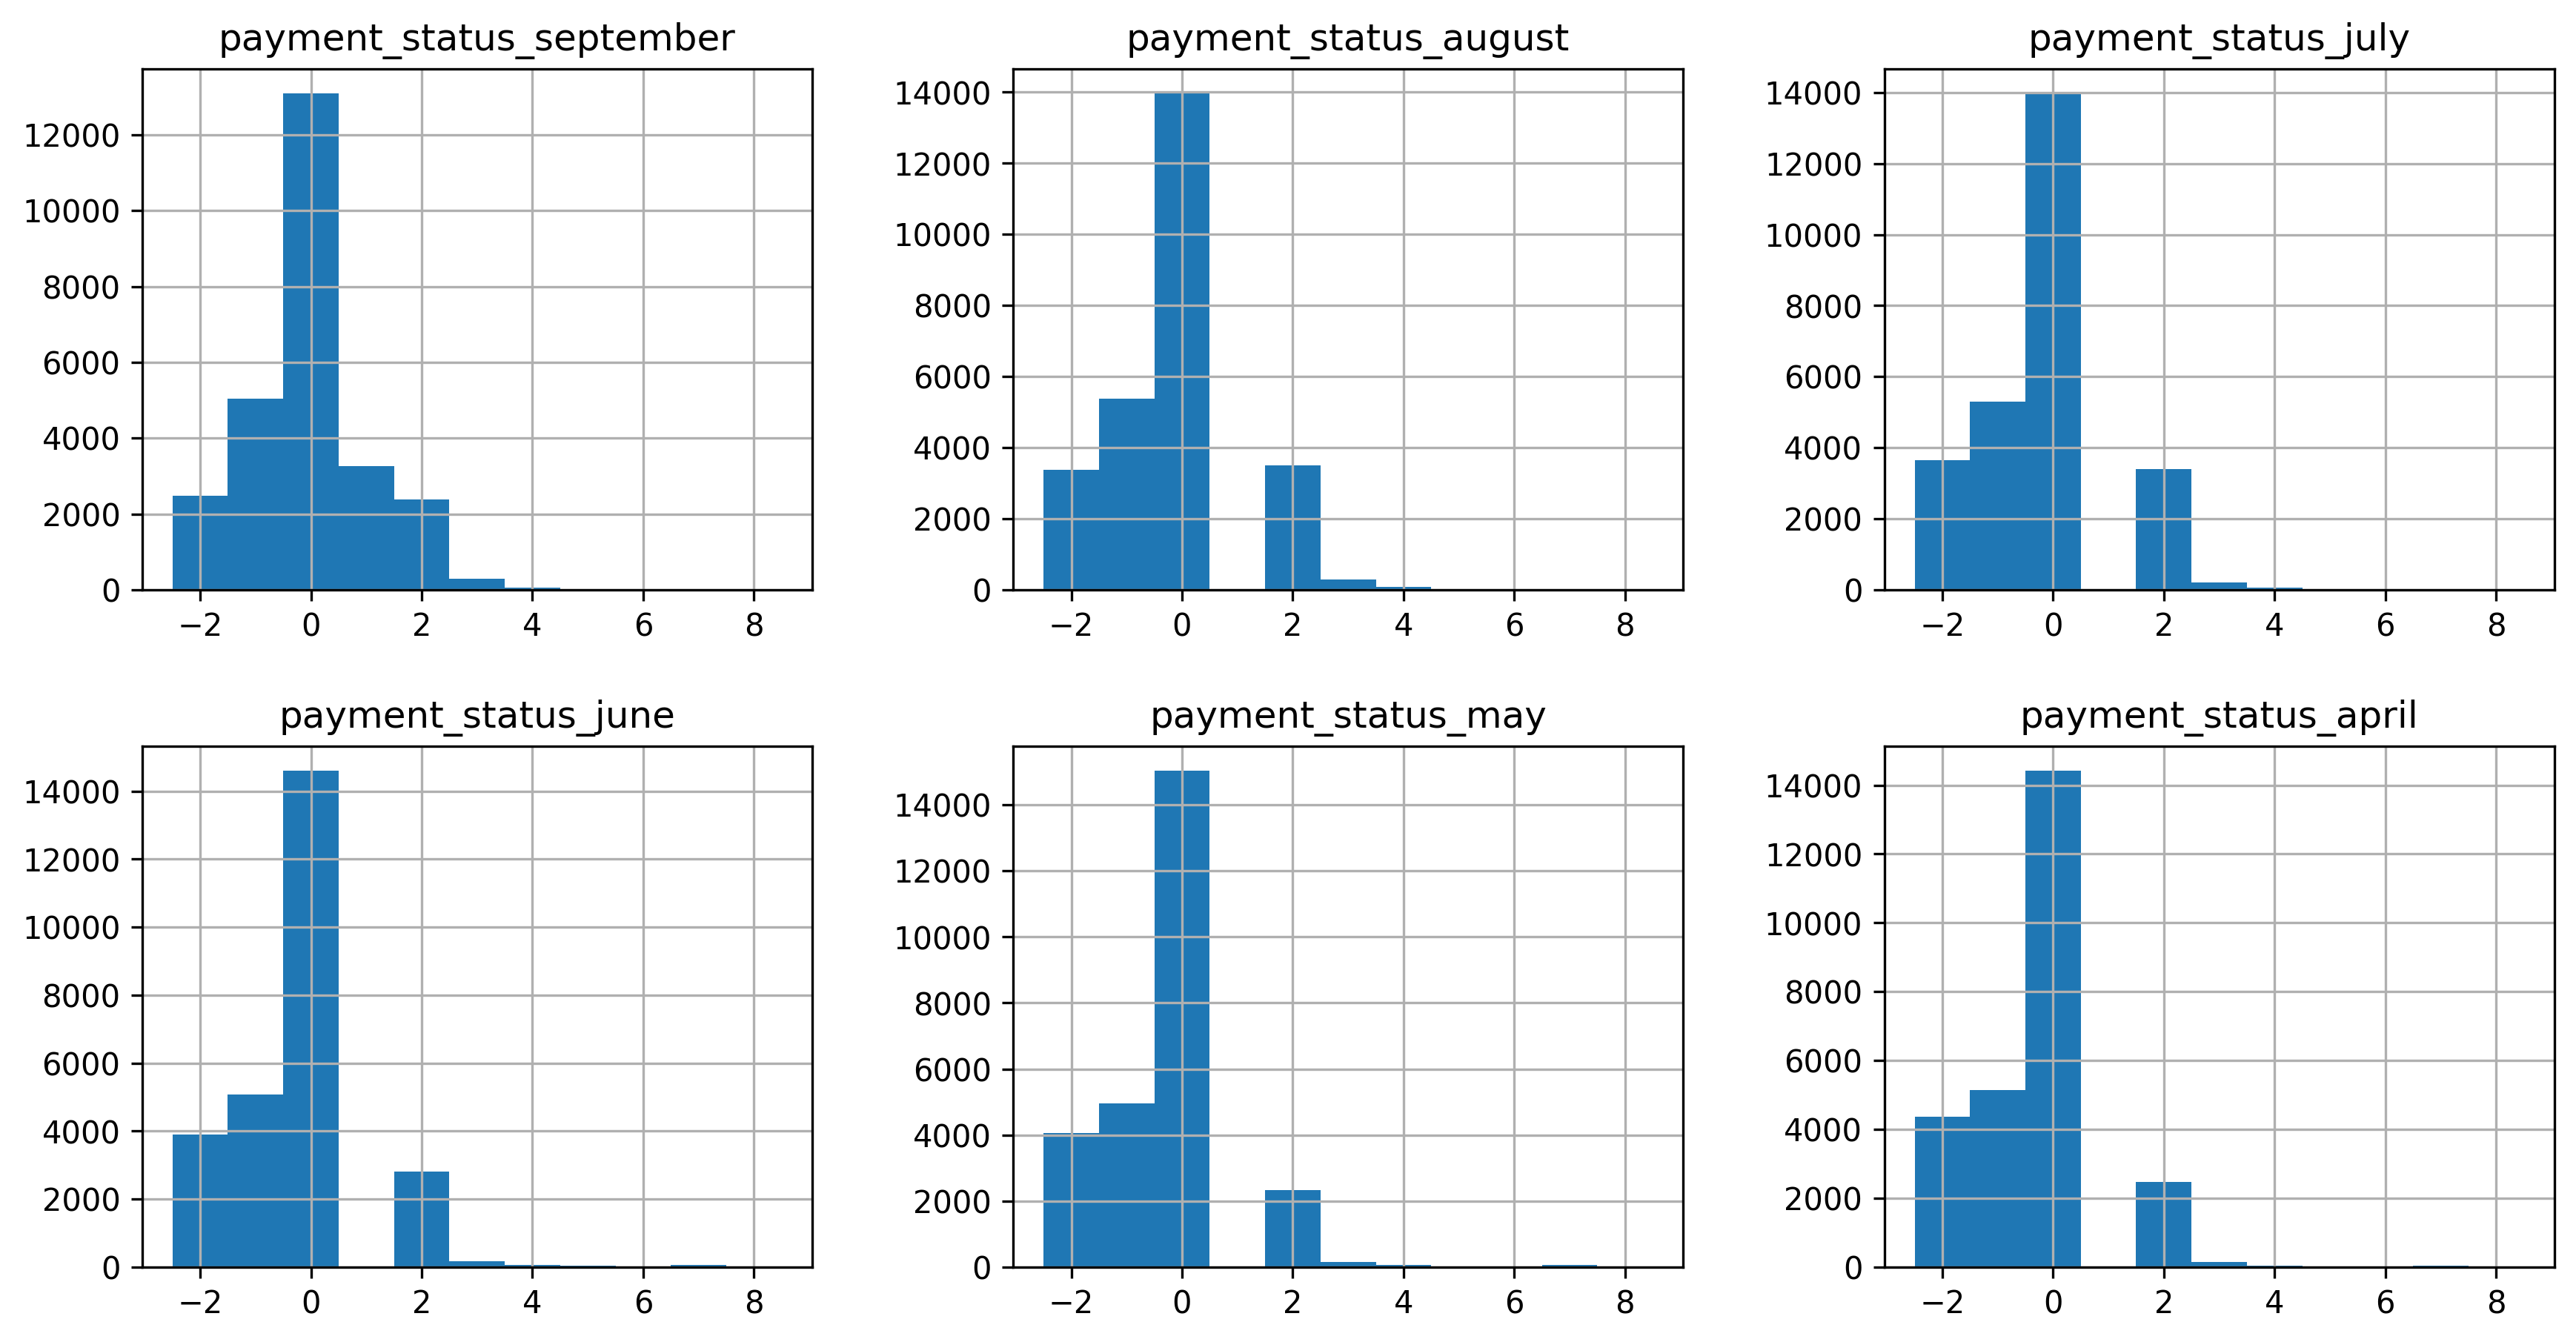

In [ ]:
data_with_education_encoded[payment_status_features].hist(bins=payment_status_bins, layout=(2, 3), figsize=(14, 7));

Let's compare the payment statuses for July (`payment_status_july`) and August (`payment_status_august`). In July, very few accounts had a one-month delay, making that bar barely visible in the histogram. However, in August, thousands of accounts suddenly show a two-month delay. This discrepancy doesn't make sense, as the number of accounts with a two-month delay should not exceed those with a one-month delay in the prior month.

Let's take a closer look at accounts with a 2-month delay in August and see their payment status in July.

In [ ]:
data_with_education_encoded.loc[data_with_education_encoded['payment_status_august'] == 2,
 ['payment_status_august', 'payment_status_july']].head()

,payment_status_august,payment_status_july
0,2,-1
1,2,0
13,2,2
15,2,0
50,2,2


Accounts with a 2-month delay in August show inconsistent July payment status values. Progressing to a 2-month delay should require a 1-month delay in the prior month, but none of these accounts reflect that.

After contacting our client, we learned they had issues pulling recent payment data, leading to underreporting of 1-month delays. This issue affected all months except September (`payment_status_september`), where reporting was mostly corrected.

Since a predictive model requires consistent data, we can use `payment_status_september` but must exclude `payment_status_august` and earlier months from the model.

In [ ]:
bill_amount_features = [
    'bill_amount_september_ntd',
    'bill_amount_august_ntd',
    'bill_amount_july_ntd',
    'bill_amount_june_ntd',
    'bill_amount_may_ntd',
    'bill_amount_april_ntd'
]
data_with_education_encoded[bill_amount_features].describe()

,bill_amount_september_ntd,bill_amount_august_ntd,bill_amount_july_ntd,bill_amount_june_ntd,bill_amount_may_ntd,bill_amount_april_ntd
count,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000
mean,51405.730723,49300.001500,47026.340047,43338.894539,40338.136701,38889.872337
std,73633.687106,70934.549534,68705.359524,64275.250740,60705.944083,59432.541657
min,-165580.000000,-69777.000000,-157264.000000,-170000.000000,-81334.000000,-339603.000000
25%,3580.000000,2999.750000,2627.250000,2341.750000,1745.000000,1256.000000
50%,22361.000000,21150.000000,20079.500000,19037.000000,18066.000000,17005.000000
75%,67649.750000,64395.500000,60360.000000,54727.500000,50290.500000,49253.750000
max,746814.000000,671563.000000,855086.000000,706864.000000,823540.000000,699944.000000


The average monthly bill ranges from 40,000 to 50,000 NTD and seems reasonable. Negative bill amounts may result from overpayments, leaving the account with a credit balance.

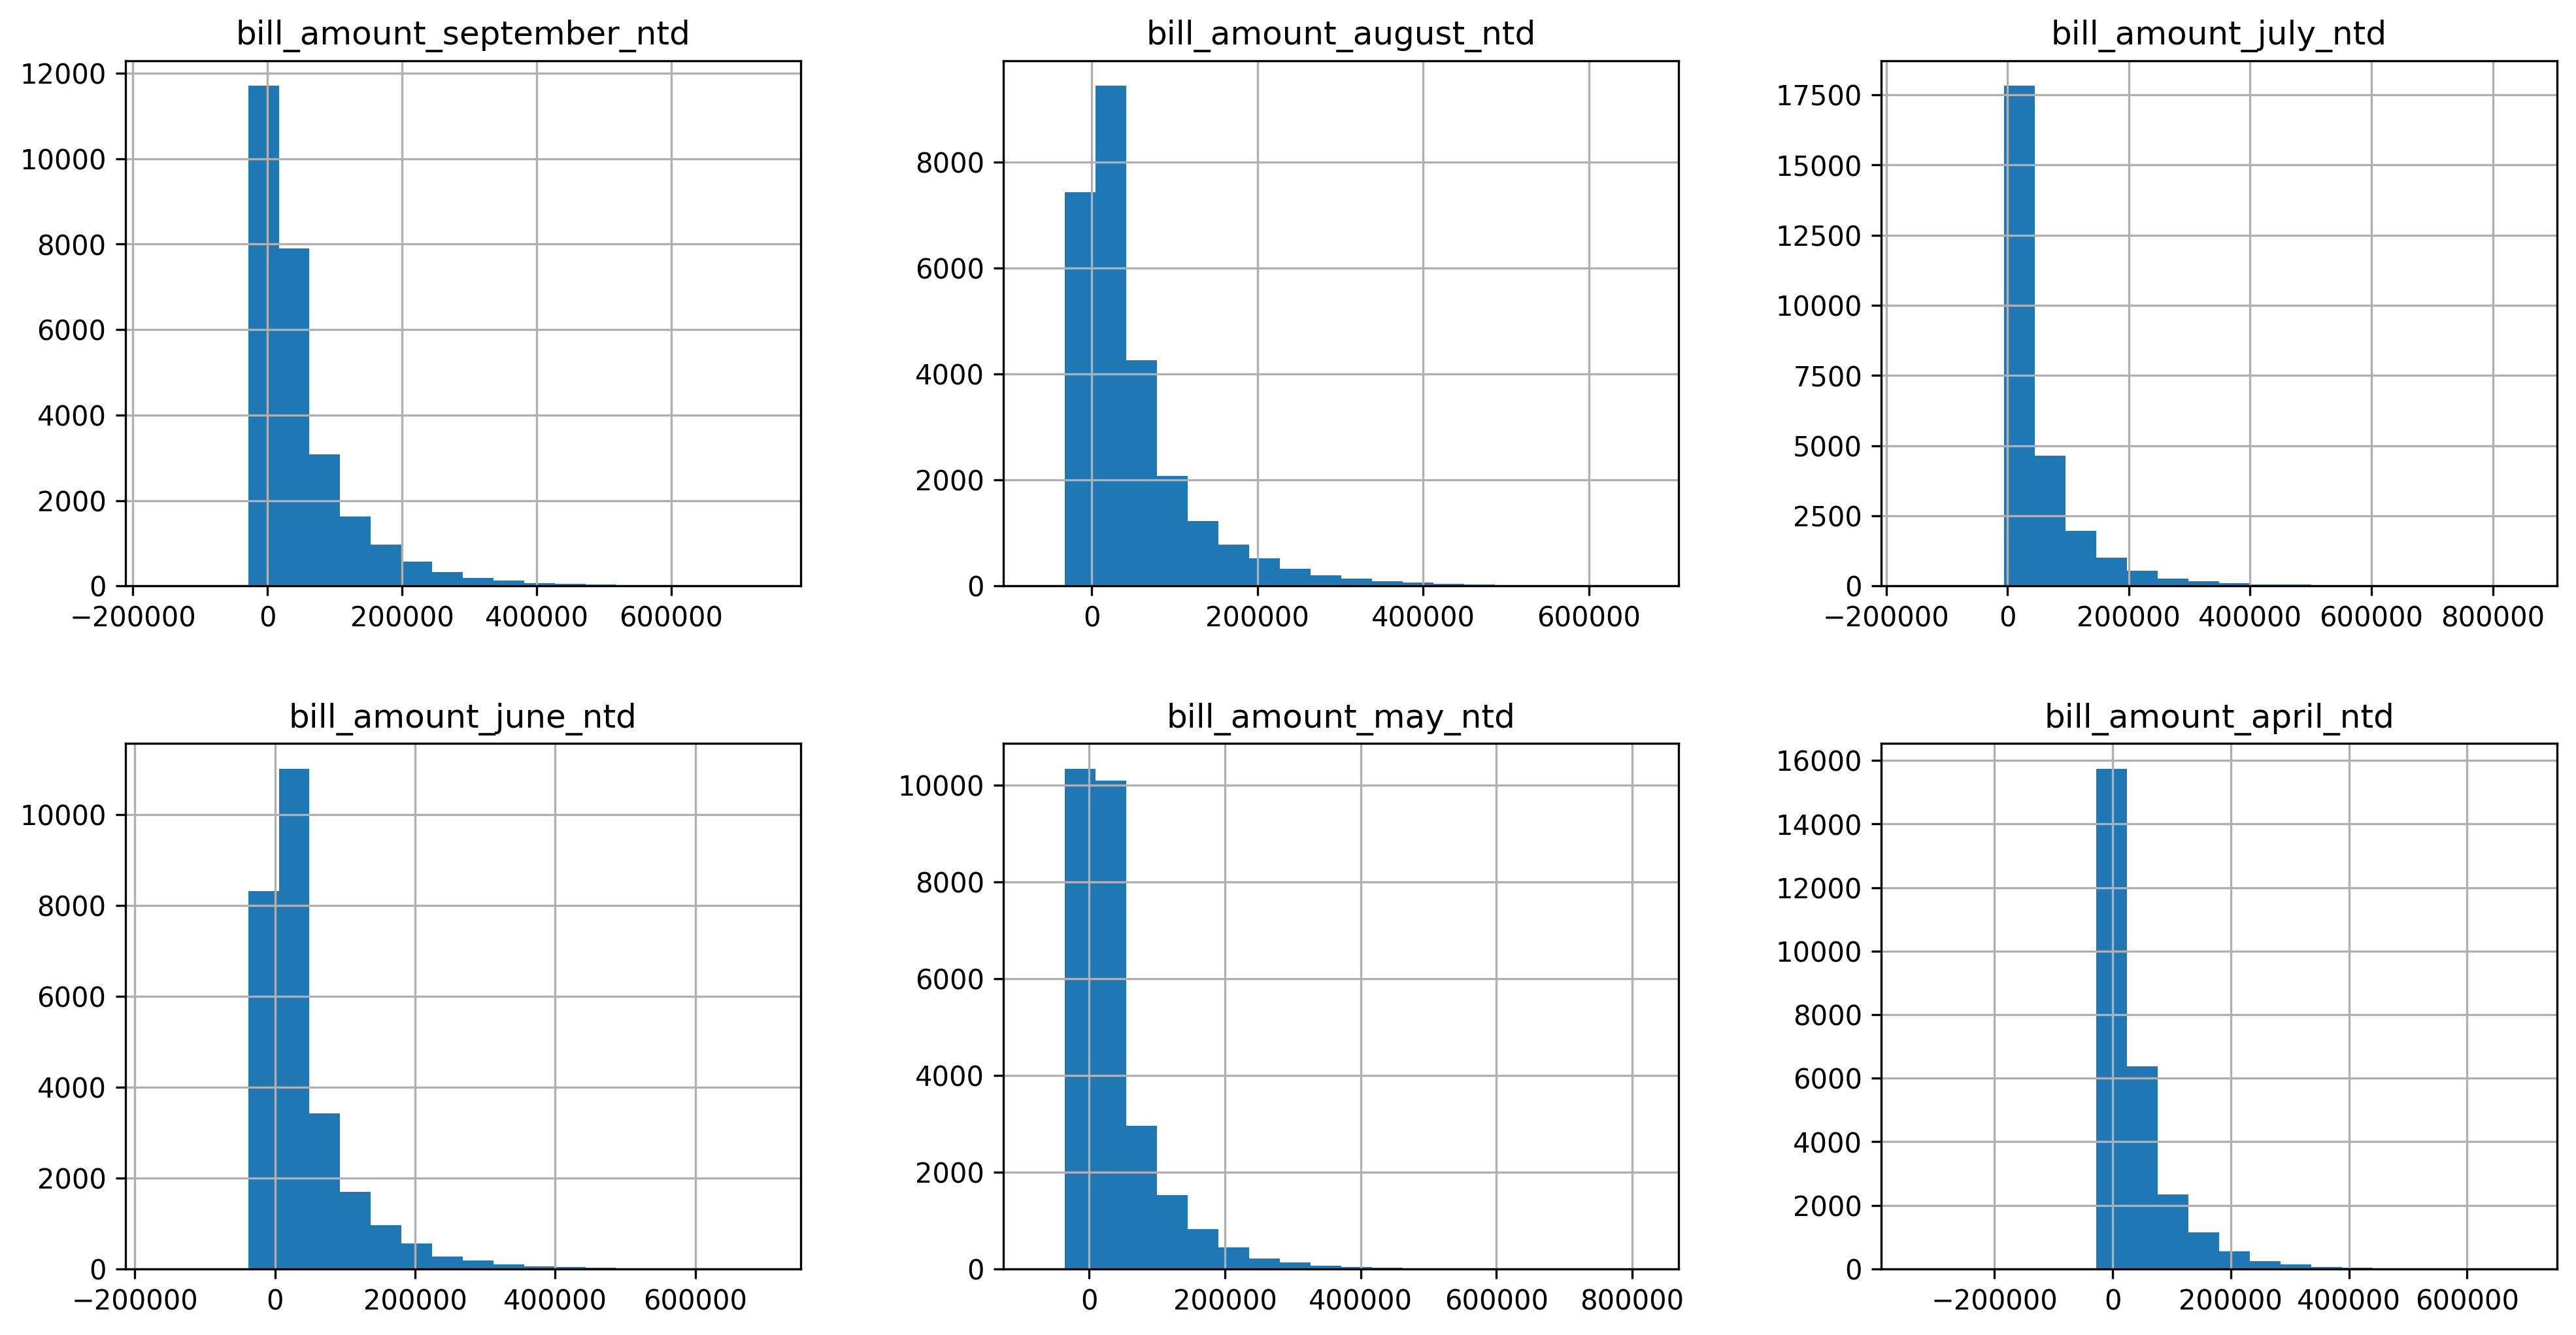

In [ ]:
data_with_education_encoded[bill_amount_features].hist(bins=20, layout=(2, 3), figsize=(16, 8));

Most accounts have relatively small bills, with fewer accounts as bill amounts increase. Unlike the payment status features, the distribution of billed amounts is consistent across months.

In [ ]:
payment_amount_features = [
    'payment_amount_september_ntd',
    'payment_amount_august_ntd',
    'payment_amount_july_ntd',
    'payment_amount_june_ntd',
    'payment_amount_may_ntd',
    'payment_amount_april_ntd'
]
data_with_education_encoded[payment_amount_features].describe()

,payment_amount_september_ntd,payment_amount_august_ntd,payment_amount_july_ntd,payment_amount_june_ntd,payment_amount_may_ntd,payment_amount_april_ntd
count,26664.000000,2.666400e+04,26664.000000,26664.000000,26664.000000,26664.000000
mean,5704.085771,5.881110e+03,5259.514964,4887.048717,4843.729973,5257.843047
std,16699.398632,2.121431e+04,17265.439561,15956.349371,15311.721795,17635.468185
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,8.020000e+02,390.000000,294.750000,242.750000,111.000000
50%,2114.500000,2.007000e+03,1822.000000,1500.000000,1500.000000,1500.000000
75%,5027.000000,5.000000e+03,4556.250000,4050.500000,4082.750000,4015.000000
max,873552.000000,1.227082e+06,889043.000000,621000.000000,426529.000000,528666.000000


The average payment amounts are about ten times lower than the average bills, indicating most accounts don't pay off their entire balance monthly. This aligns with our exploration, where the most common payment status showed minimum payments. Notably, there are no negative payments, which seems reasonable.

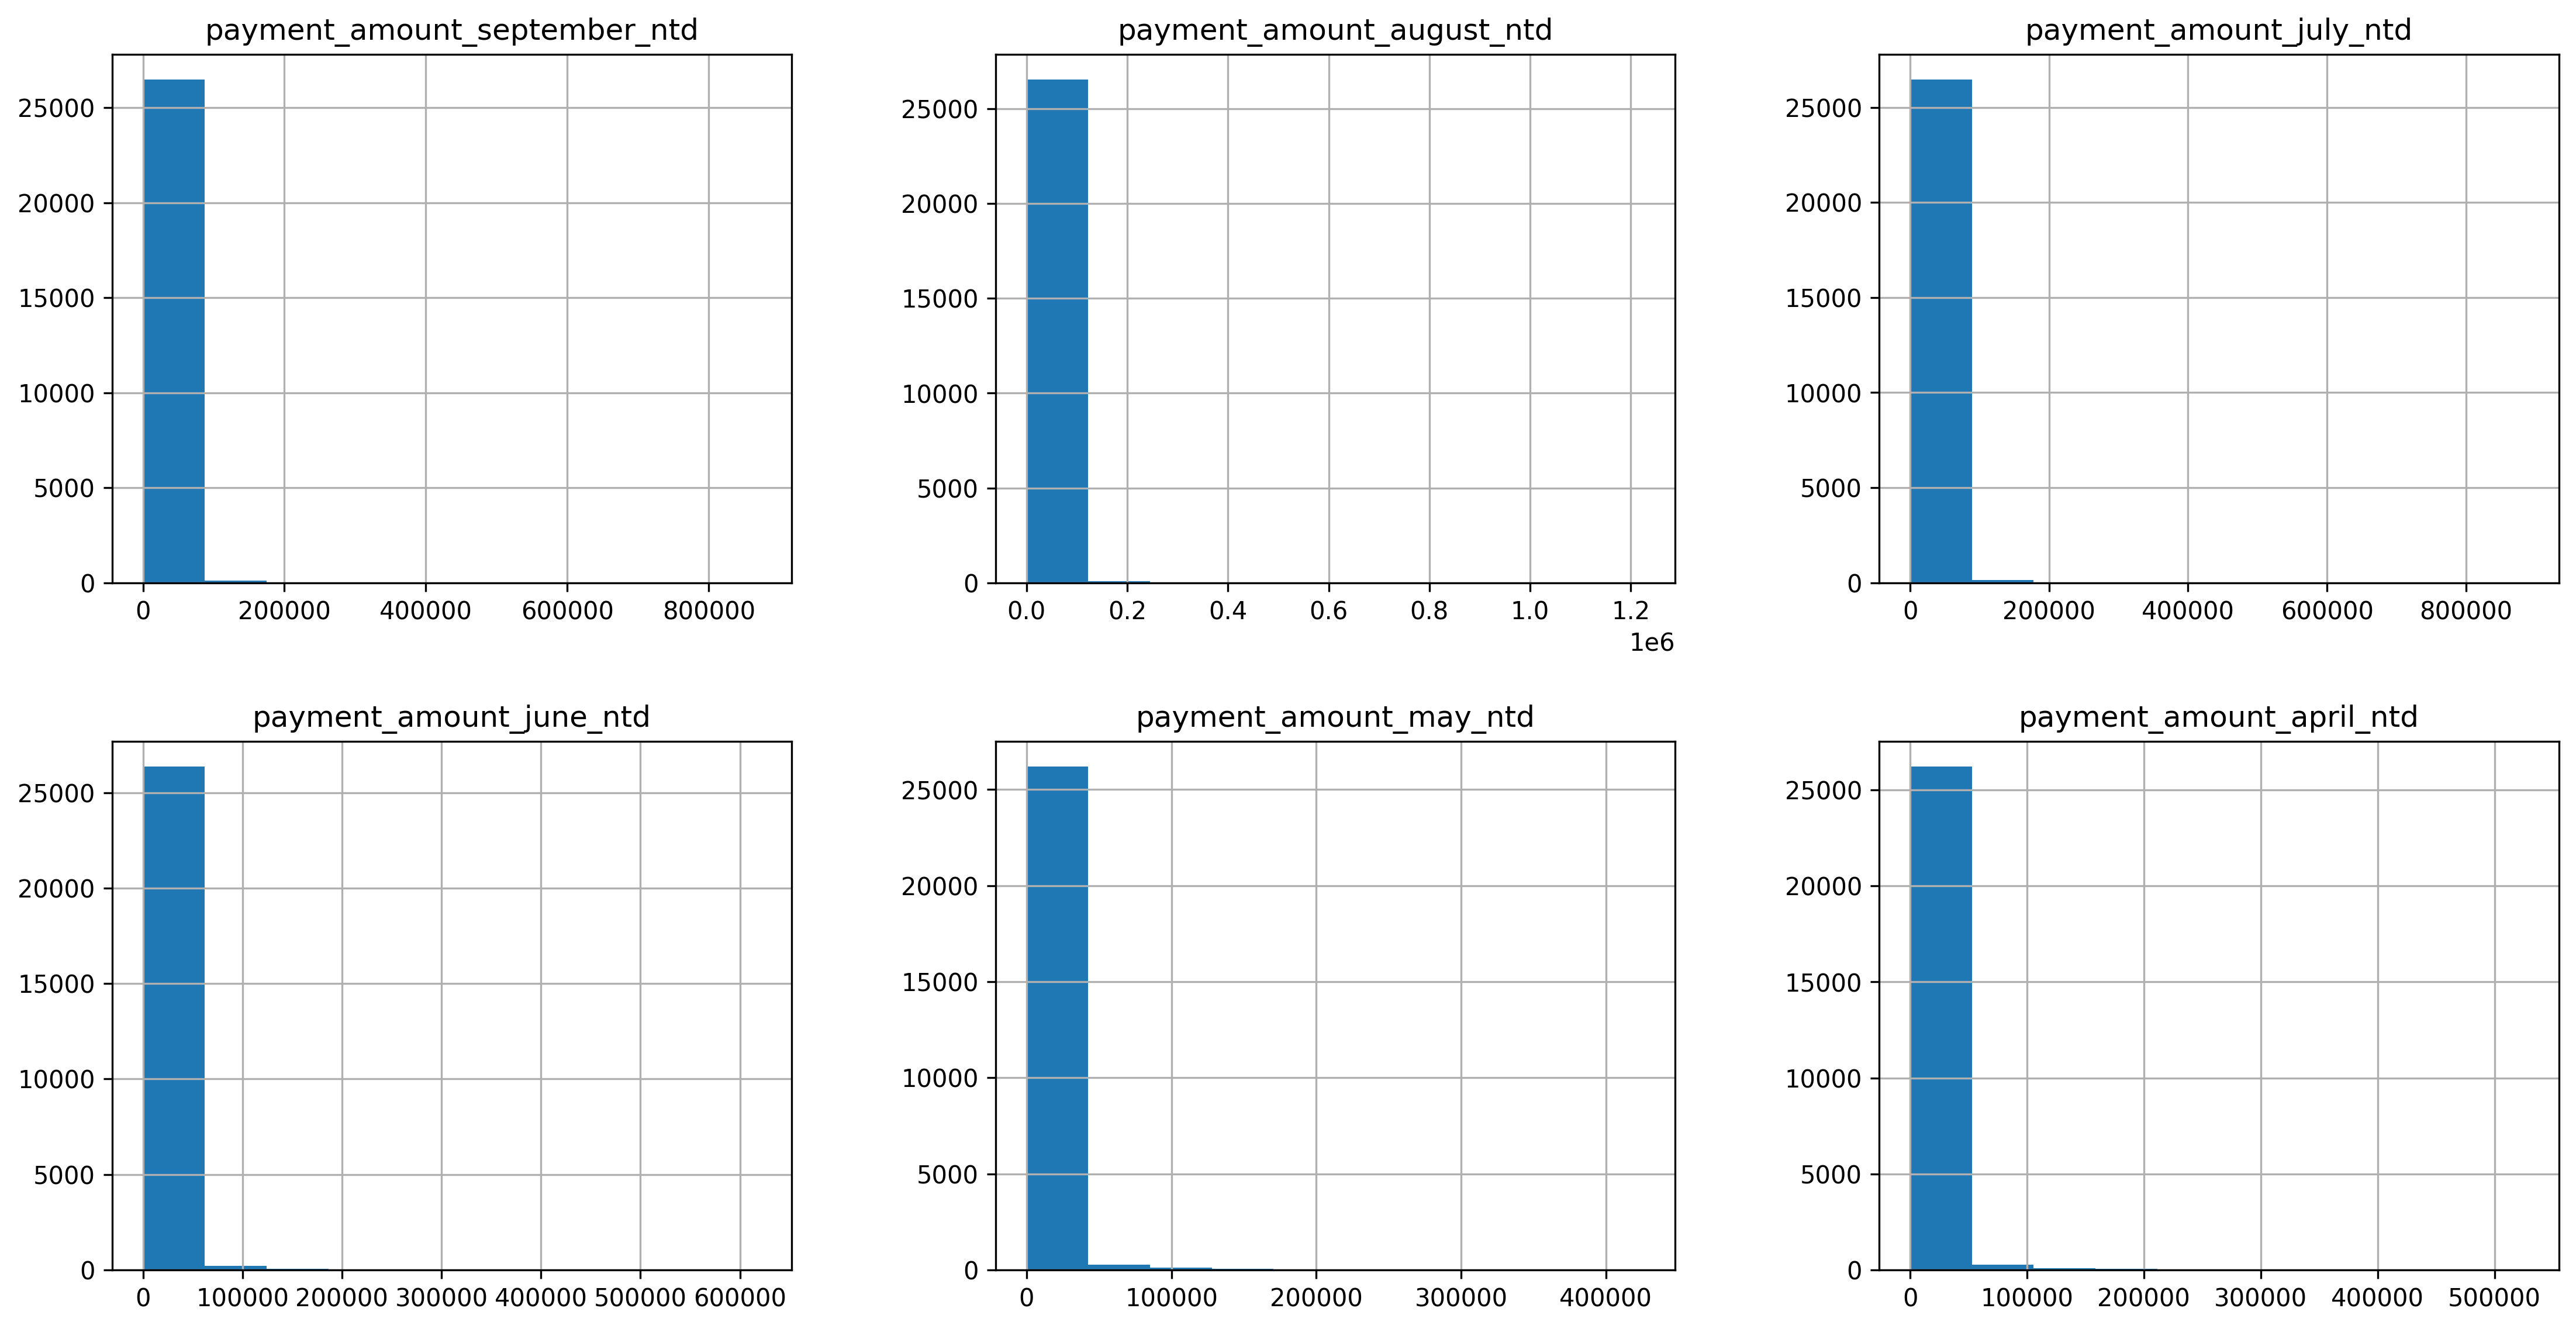

In [ ]:
data_with_education_encoded[payment_amount_features].hist(layout=(2, 3), figsize=(18, 9));

The graphic could be more informative as most histograms only have one noticeable peak. Most monthly payment amounts fall into a single bin, including 0. How many payments are 0?

In [ ]:
payment_amount_zero_mask = data_with_education_encoded[payment_amount_features] == 0
payment_amount_zero_mask.sum()

,0
payment_amount_september_ntd,4656
payment_amount_august_ntd,4833
payment_amount_july_ntd,5293
payment_amount_june_ntd,5697
payment_amount_may_ntd,5981
payment_amount_april_ntd,6373


In any month, 20-25% of accounts have a bill payment of 0, but most payments are above 0. The histogram hides this due to the wide range of values—maximum payments are about 100 times higher than the average. Since large payments are rare, equal-sized bins lump most data into the smallest bin.

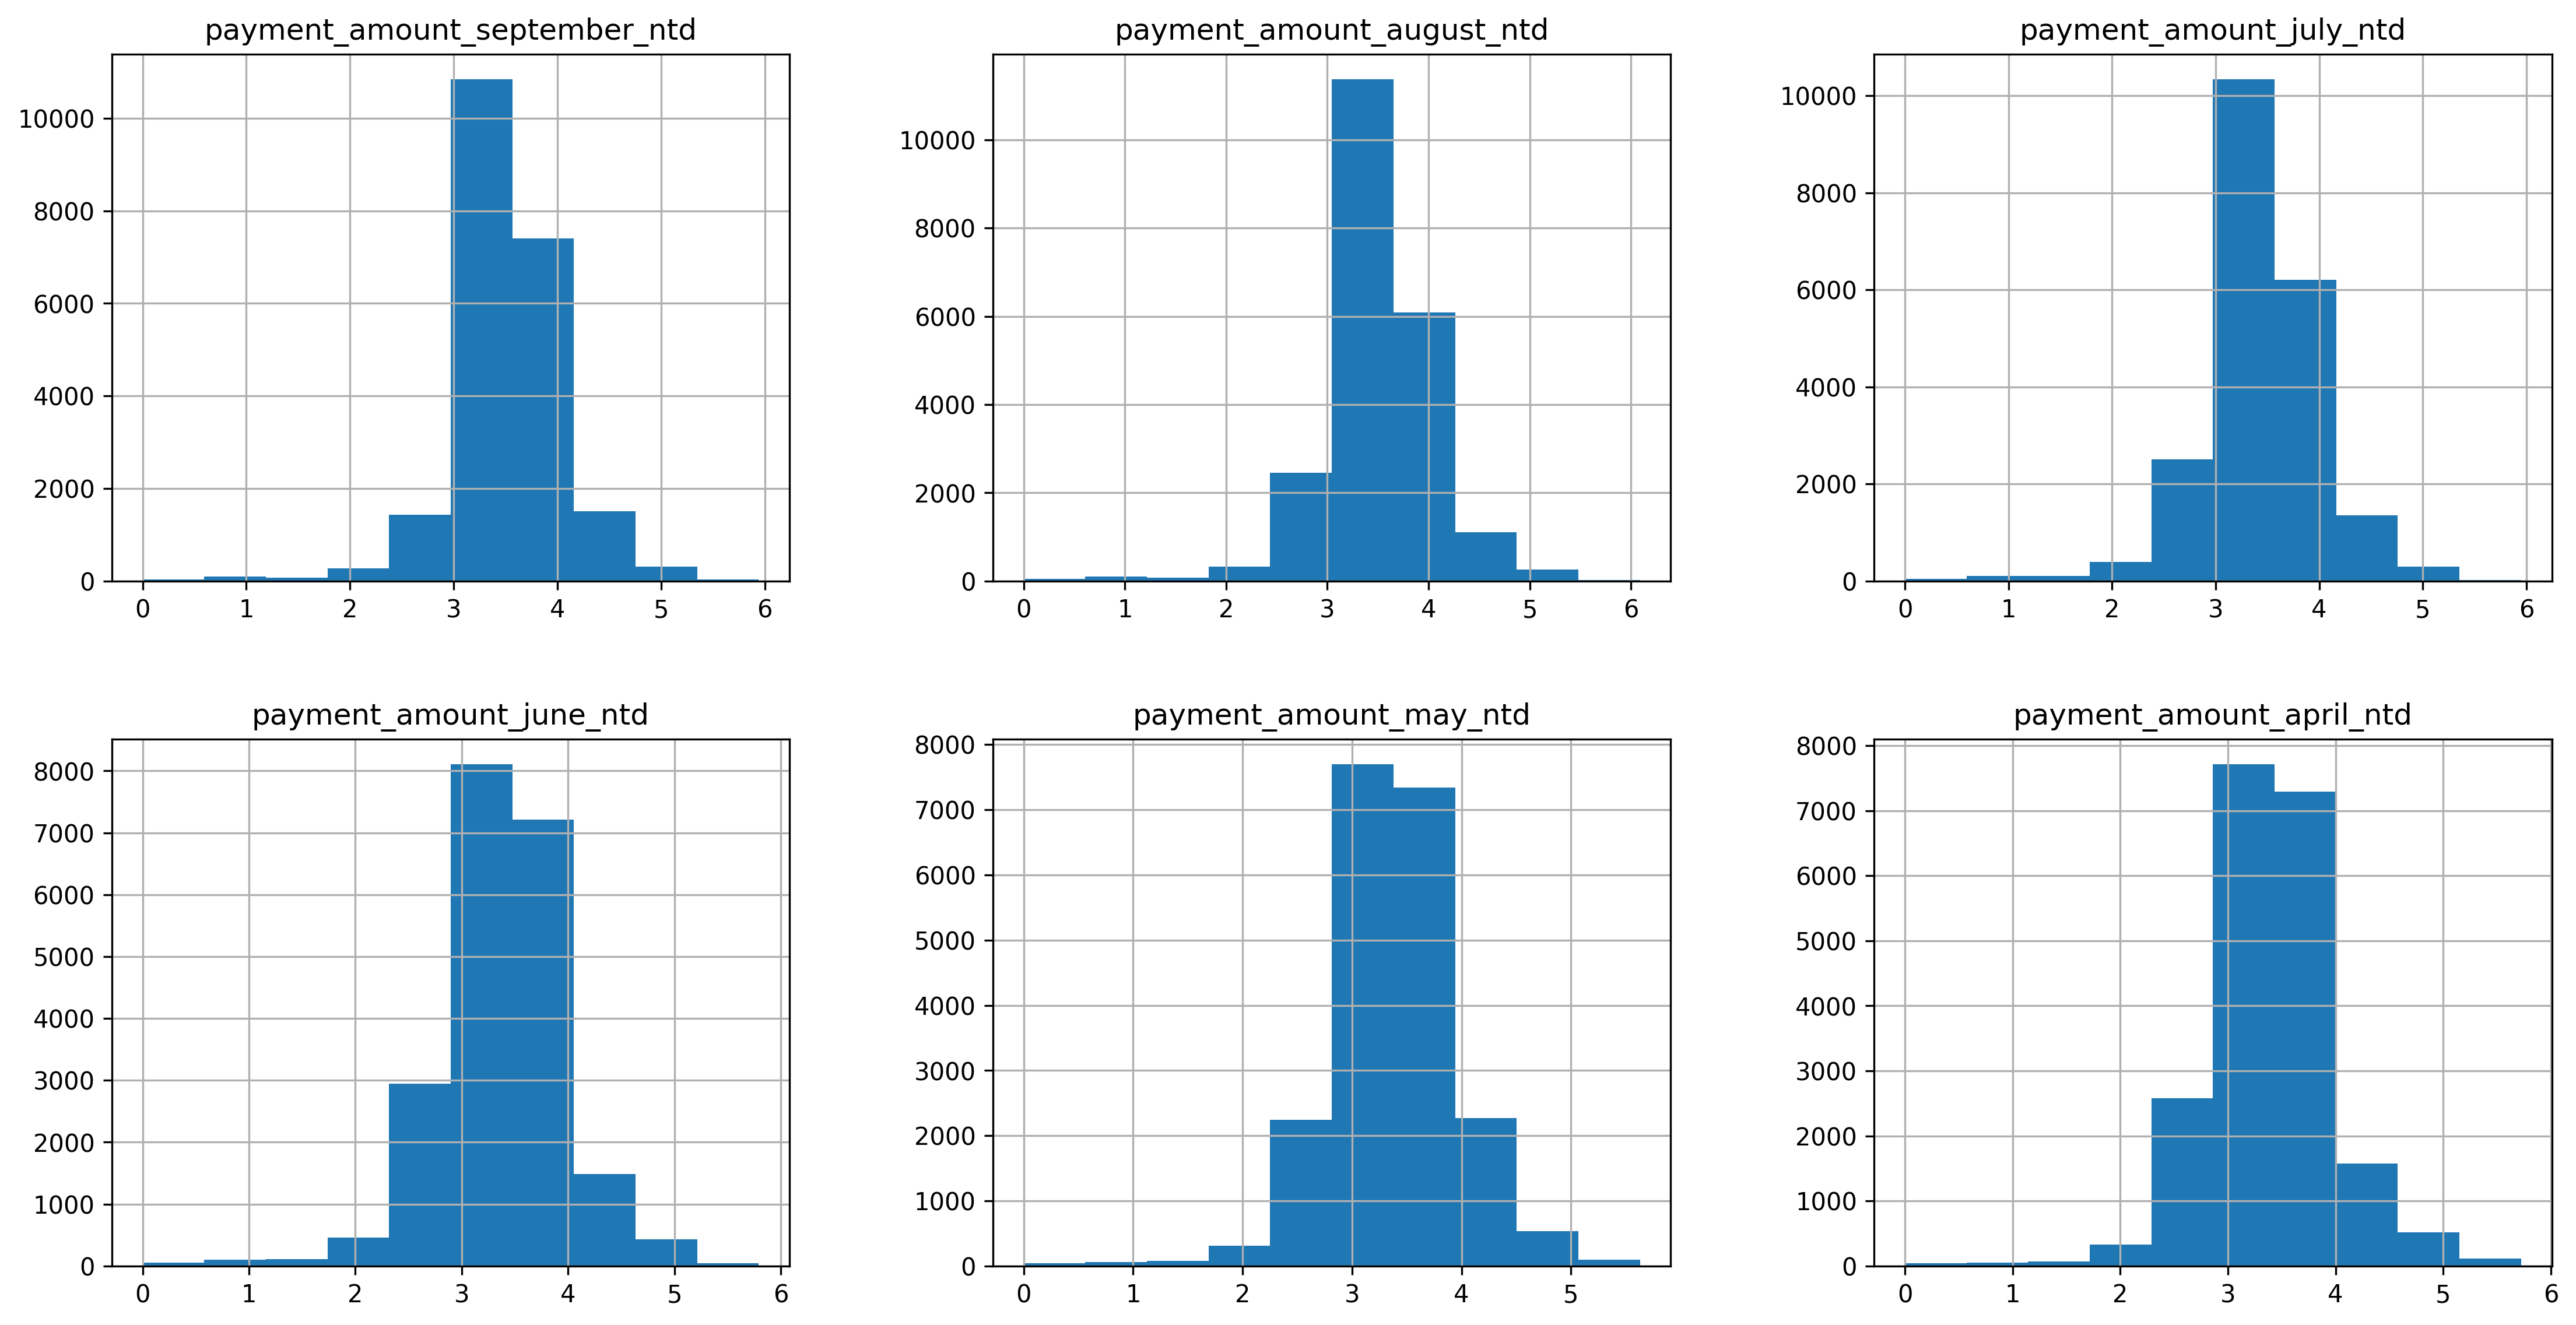

In [ ]:
data_with_education_encoded[payment_amount_features][~payment_amount_zero_mask].apply(np.log10).hist(layout=(2, 3), figsize=(18, 9));
# A base-10 log shows how many zeros a value has; however, log10​(0) is undefined.

The log transformation enhances the histogram by distributing values more evenly. Most bill payments are in the thousands, with log10(1,000) equal to 3, which aligns with the mean from the summary. The data shows a steady distribution of small payments with a few large ones each month, indicating no issues.

In our data, accounts with `default payment next month` = 1 are the positive class, while non-defaults are the negative class.

In [ ]:
data_with_education_encoded['default_next_month'].mean()

0.2217971797179718

In [ ]:
data_with_education_encoded['default_next_month'].value_counts()

,count
default_next_month,
0,20750
1,5914


Since the target variable can be either 1 or 0, calculating the mean of this column gives us the fraction of accounts that have defaulted, which is 22%. While our data is not strictly balanced, we also note that a positive class fraction of 22% is not particularly imbalanced.

In [ ]:
features_response = data_with_education_encoded.columns.tolist()
features_response

['credit_limit_ntd',
 'gender',
 'education_level',
 'marital_status',
 'age_years',
 'payment_status_september',
 'payment_status_august',
 'payment_status_july',
 'payment_status_june',
 'payment_status_may',
 'payment_status_april',
 'bill_amount_september_ntd',
 'bill_amount_august_ntd',
 'bill_amount_july_ntd',
 'bill_amount_june_ntd',
 'bill_amount_may_ntd',
 'bill_amount_april_ntd',
 'payment_amount_september_ntd',
 'payment_amount_august_ntd',
 'payment_amount_july_ntd',
 'payment_amount_june_ntd',
 'payment_amount_may_ntd',
 'payment_amount_april_ntd',
 'default_next_month',
 'education_cat',
 'graduate school',
 'high school',
 'other',
 'university']

We will exclude the `gender` variable due to ethical considerations. The columns `payment_status_august`, `payment_status_july`, `payment_status_june`, `payment_status_may`, and `payment_status_april` are incorrect and will be disregarded. Additionally, the one-hot encoded `education_level` variable will be excluded, as the original `education_level` feature already encompasses this information.

In [ ]:
columns_to_exclude = [
    'gender', 'payment_status_august', 'payment_status_july',
    'payment_status_june', 'payment_status_may', 'payment_status_april',
    'education_cat', 'graduate school', 'high school', 'other', 'university'
    ]

In [ ]:
features_response = [item for item in features_response if item not in columns_to_exclude]
features_response

['credit_limit_ntd',
 'education_level',
 'marital_status',
 'age_years',
 'payment_status_september',
 'bill_amount_september_ntd',
 'bill_amount_august_ntd',
 'bill_amount_july_ntd',
 'bill_amount_june_ntd',
 'bill_amount_may_ntd',
 'bill_amount_april_ntd',
 'payment_amount_september_ntd',
 'payment_amount_august_ntd',
 'payment_amount_july_ntd',
 'payment_amount_june_ntd',
 'payment_amount_may_ntd',
 'payment_amount_april_ntd',
 'default_next_month']

Features that are highly correlated with the response are often useful for prediction, but other factors like multicollinearity, non-linear relationships, and domain relevance should also be considered when selecting predictors.

In [ ]:
corr = data_with_education_encoded[features_response].corr()
corr

,credit_limit_ntd,education_level,marital_status,age_years,payment_status_september,bill_amount_september_ntd,bill_amount_august_ntd,bill_amount_july_ntd,bill_amount_june_ntd,bill_amount_may_ntd,bill_amount_april_ntd,payment_amount_september_ntd,payment_amount_august_ntd,payment_amount_july_ntd,payment_amount_june_ntd,payment_amount_may_ntd,payment_amount_april_ntd,default_next_month
credit_limit_ntd,1.000000,-0.232688,-0.111873,0.149157,-0.273396,0.287009,0.279289,0.285299,0.294342,0.295198,0.289818,0.194820,0.188049,0.207638,0.202795,0.218082,0.221305,-0.154423
education_level,-0.232688,1.000000,-0.137097,0.179035,0.112653,0.016156,0.012307,0.007683,-0.005862,-0.013174,-0.012670,-0.040092,-0.033610,-0.042349,-0.039319,-0.044946,-0.046859,0.034966
marital_status,-0.111873,-0.137097,1.000000,-0.412828,0.019759,-0.028610,-0.026009,-0.029192,-0.027740,-0.029895,-0.024414,-0.002951,-0.007548,-0.003408,-0.014387,-0.000410,-0.009461,-0.026030
age_years,0.149157,0.179035,-0.412828,1.000000,-0.044277,0.056245,0.054099,0.054107,0.051241,0.049701,0.047519,0.025437,0.025421,0.029876,0.025307,0.020541,0.021640,0.014334
payment_status_september,-0.273396,0.112653,0.019759,-0.044277,1.000000,0.185826,0.188799,0.181257,0.178812,0.180438,0.177486,-0.081450,-0.073295,-0.072682,-0.064112,-0.057021,-0.061031,0.325365
bill_amount_september_ntd,0.287009,0.016156,-0.028610,0.056245,0.185826,1.000000,0.951651,0.900386,0.860149,0.828615,0.802008,0.138221,0.112460,0.145635,0.160204,0.163425,0.178943,-0.020508
bill_amount_august_ntd,0.279289,0.012307,-0.026009,0.054099,0.188799,0.951651,1.000000,0.937488,0.892103,0.858078,0.830300,0.276583,0.114473,0.137514,0.148685,0.153851,0.172472,-0.014579
bill_amount_july_ntd,0.285299,0.007683,-0.029192,0.054107,0.181257,0.900386,0.937488,1.000000,0.930385,0.889186,0.855154,0.242809,0.287837,0.119456,0.141010,0.159446,0.178121,-0.014649
bill_amount_june_ntd,0.294342,-0.005862,-0.027740,0.051241,0.178812,0.860149,0.892103,0.930385,1.000000,0.937799,0.899241,0.229123,0.217716,0.293652,0.131700,0.158633,0.171339,-0.011349
bill_amount_may_ntd,0.295198,-0.013174,-0.029895,0.049701,0.180438,0.828615,0.858078,0.889186,0.937799,1.000000,0.945671,0.212053,0.189566,0.241291,0.296192,0.140669,0.161847,-0.006753


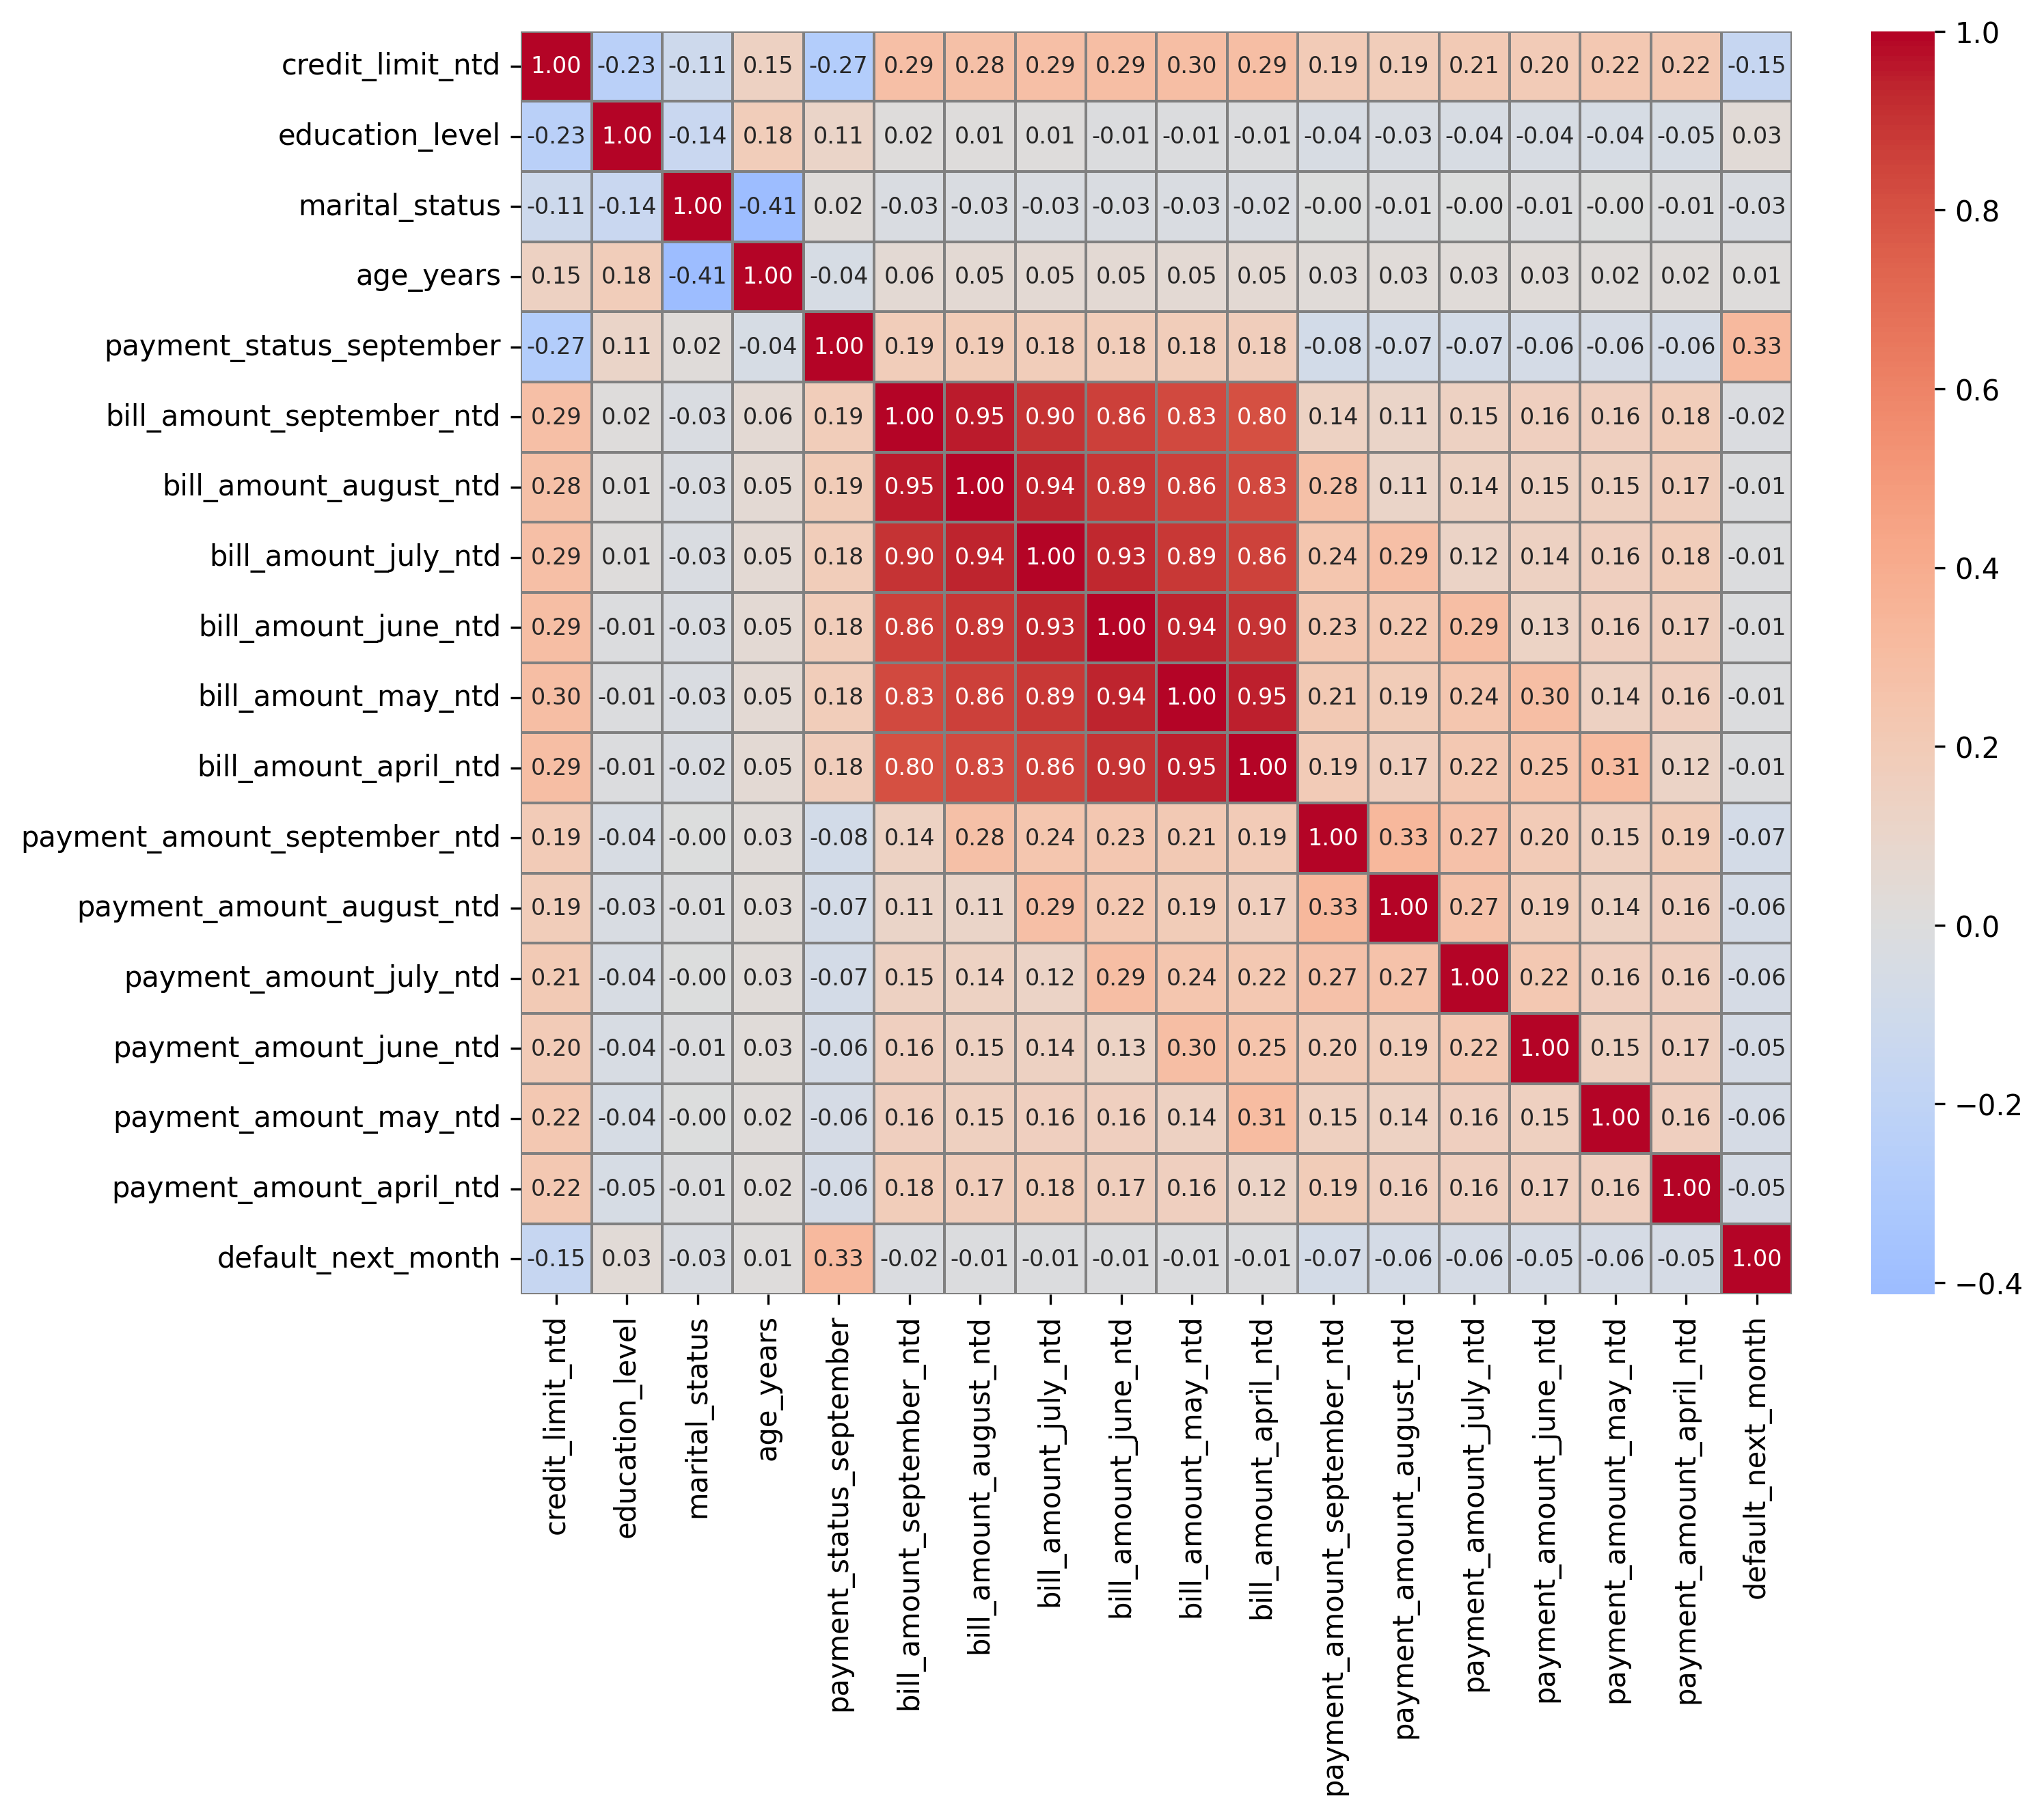

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', annot_kws={'size': 8},
            xticklabels=corr.columns.values, yticklabels=corr.columns.values,
            center=0, cmap='coolwarm', linewidths=0.5, linecolor='gray');

The F-test p-value answers: "How likely is it that the average value of this feature is the same between positive and negative classes?" A low p-value indicates that the averages are likely different, suggesting the feature could effectively discriminate between the classes.

In [ ]:
X = data_with_education_encoded[features_response].iloc[:, :-1].values
y = data_with_education_encoded[features_response].iloc[:, -1].values
print(X.shape)
print(y.shape)

(26664, 17)
(26664,)


In [ ]:
[f_stat, p_val] = f_classif(X, y)
f_test = pd.DataFrame({'F-statistic': f_stat,
                       'p-value': p_val},
                      index=features_response[:-1])
f_test.sort_values('p-value')

,F-statistic,p-value
payment_status_september,3156.672300,0.000000e+00
credit_limit_ntd,651.324071,5.838366e-142
payment_amount_september_ntd,140.612679,2.358354e-32
payment_amount_august_ntd,101.408321,8.256124e-24
payment_amount_july_ntd,90.023873,2.542641e-21
payment_amount_may_ntd,85.843295,2.090120e-20
payment_amount_april_ntd,80.420784,3.219565e-19
payment_amount_june_ntd,79.640021,4.774112e-19
education_level,32.637768,1.122175e-08
marital_status,18.078027,2.127555e-05


`payment_status_september` and `credit_limit_ntd` are the most useful features with the smallest p-values, showing significant differences between classes and aiding class prediction.

Although the F-test assumes normality, which we did not check, and comparing multiple features to the same response introduces a multiple comparisons problem—raising the chance of identifying significant features by random chance that may not generalize well—it performed well for our analysis because:

Our univariate analysis identified `payment_status_september` as the feature with the strongest association with the response variable. This feature represents last month's payment status: values like -2 (no usage), -1 (paid in full), and 0 (minimum payment made) indicate good standing, while positive values reflect delayed payments. Since it captures past defaults,`payment_status_september` is a key predictor, as historical data often predicts future outcomes. Similarly, `credit_limit_ntd`, the credit limit, correlates with default risk, as lower limits are typically assigned to riskier clients, indicating higher default probabilities.

Thus, from our univariate feature selection, we identified likely important features and their relationships to the response variable using the correlation matrix. However, given the limitations of our tests, visualizing these relationships is crucial to confirm and better understand the data patterns.

In [ ]:
overall_default_rate = data_with_education_encoded['default_next_month'].mean()
overall_default_rate

0.2217971797179718

In [ ]:
# Group the DataFrame 'data_with_education_encoded' by the 'payment_status_september' column
# This step creates groups based on unique values in 'payment_status_september'

group_by_payment_status_mean_y = data_with_education_encoded.groupby('payment_status_september')[ # Group by the payment status
    'default_next_month' # Focus on the 'default_next_month' column for aggregation
].mean() # Calculate the mean of 'default_next_month' within each group

# The result is a Series where the index is 'payment_status_september' and the values are
# the average of 'default_next_month' for each payment status.

group_by_payment_status_mean_y

,default_next_month
payment_status_september,
-2,0.131664
-1,0.170002
0,0.128295
1,0.336400
2,0.694701
3,0.773973
4,0.682540
5,0.434783
6,0.545455


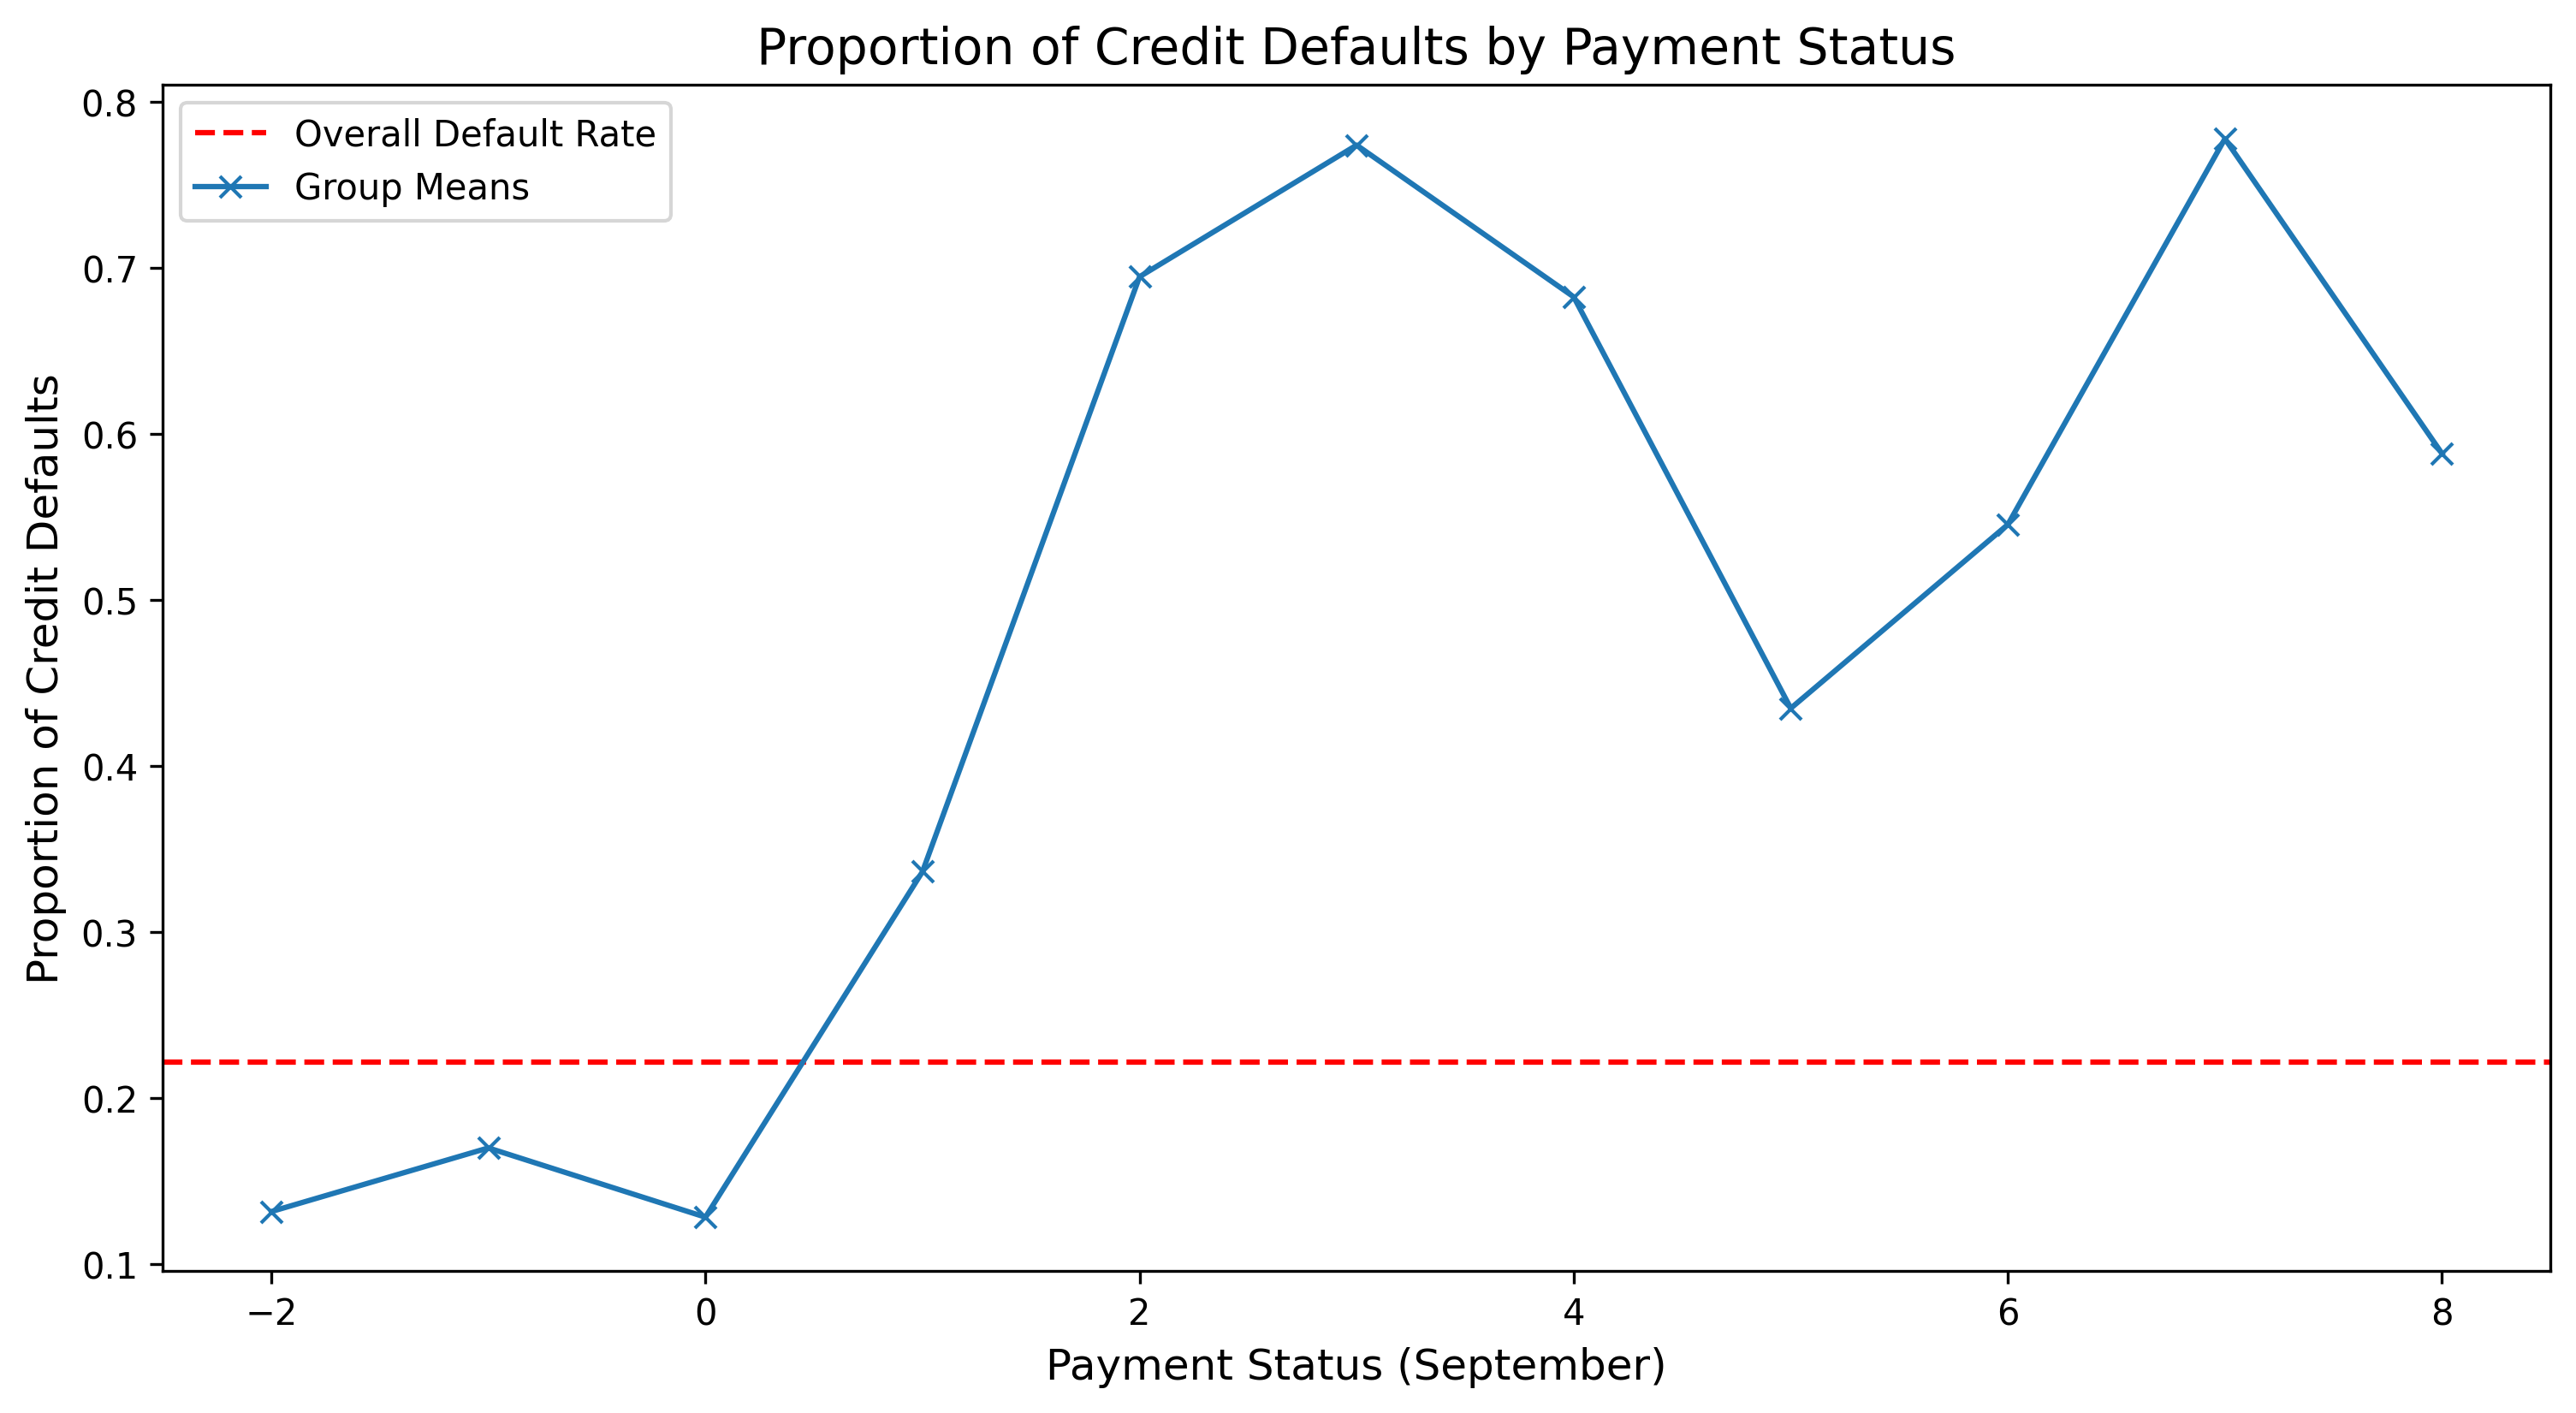

In [ ]:
plt.figure(figsize=(12, 6))
axes = plt.gca()
# Add a horizontal line to represent the overall default rate
axes.axhline(overall_default_rate, color='red', linestyle='--', linewidth=1.5, label='Overall Default Rate')
# Plot the group-wise means with markers
group_by_payment_status_mean_y.plot(marker='x', legend=False, ax=axes)
axes.set_ylabel('Proportion of Credit Defaults', fontsize=12)
axes.set_xlabel('Payment Status (September)', fontsize=12)
axes.set_title('Proportion of Credit Defaults by Payment Status', fontsize=14)
axes.legend(['Overall Default Rate', 'Group Means'], loc='best', fontsize=10);

The trend indicates that as the payment status value increases (indicating delayed payments), the default proportion rises significantly, peaking around higher delay values. This demonstrates that payment status is a strong predictor of default risk, with delayed payments correlating with higher default probabilities.

In [ ]:
pos_mask = y == 1
neg_mask = y == 0
data_with_education_encoded['credit_limit_ntd'].max()

800000

In [ ]:
bin_edges = list(range(0, 850000, 50000))
print(bin_edges)

[0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000]


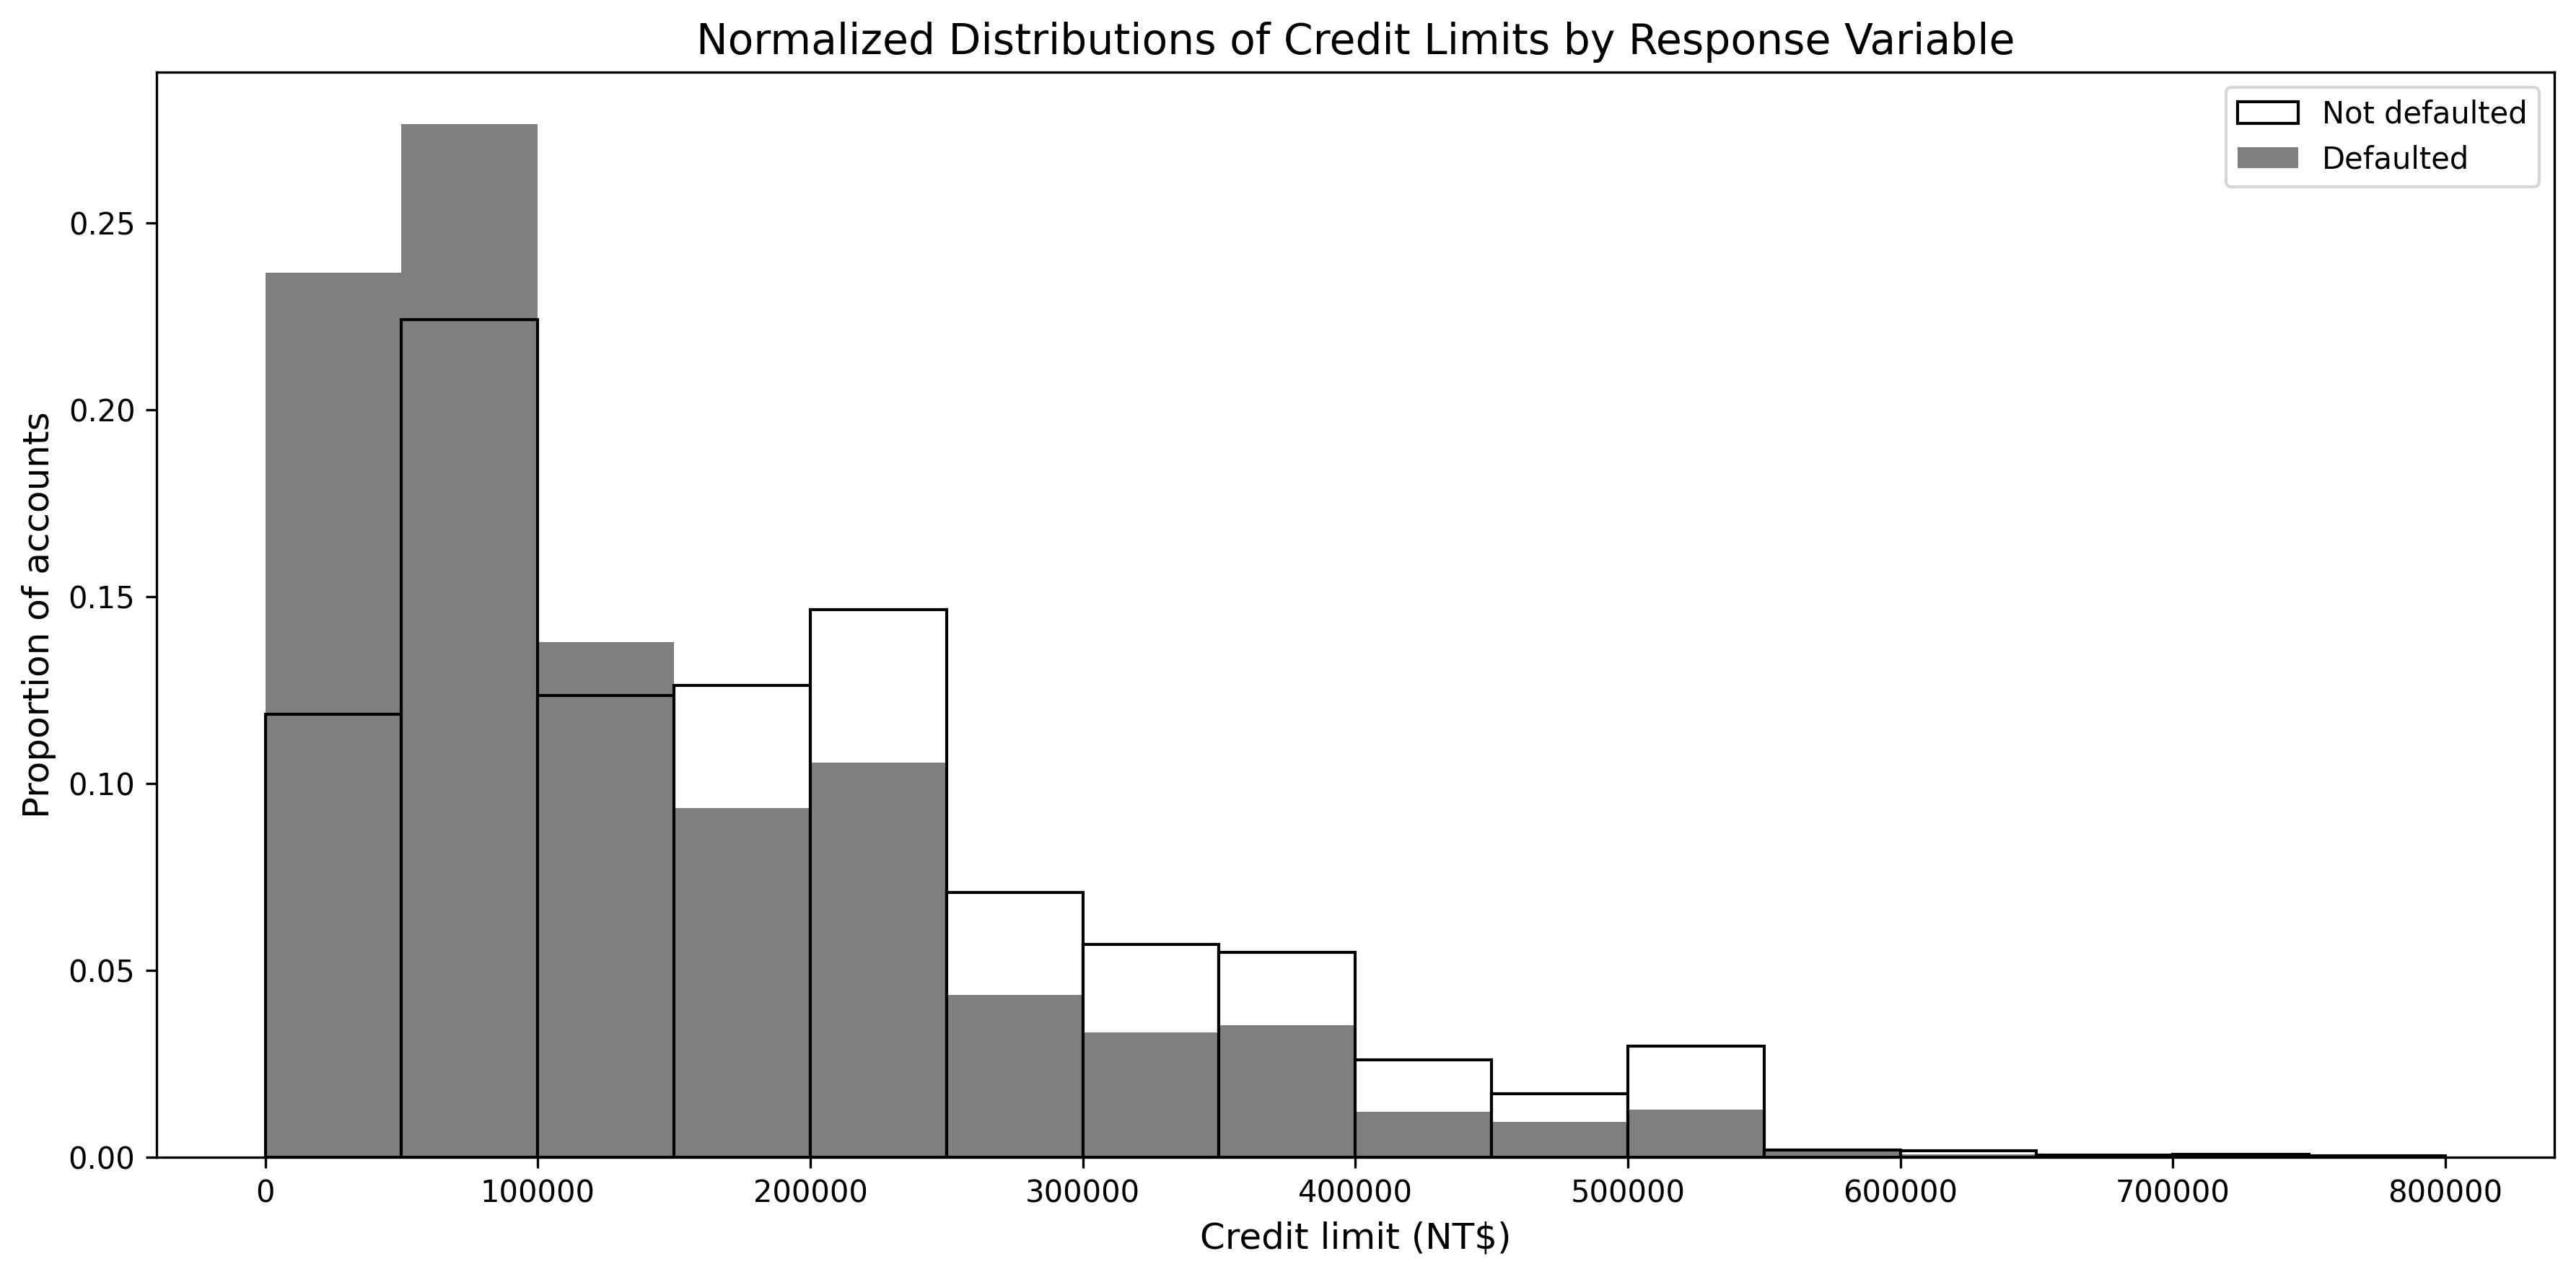

In [ ]:
plt.figure(figsize=(12, 6))
axes = plt.axes()
axes.hist(
    data_with_education_encoded.loc[neg_mask, 'credit_limit_ntd'],
    bins=bin_edges,
    density=True,
    edgecolor='black',
    color='white',
    label='Not defaulted'
)
axes.hist(
    data_with_education_encoded.loc[pos_mask, 'credit_limit_ntd'],
    bins=bin_edges,
    density=True,
    alpha=0.5,
    edgecolor=None,
    color='black',
    label='Defaulted'
)
axes.set_xlabel('Credit limit (NT$)', fontsize=12)
axes.set_ylabel('Proportion of accounts', fontsize=12)
axes.set_title('Normalized Distributions of Credit Limits by Response Variable', fontsize=14)
def format_func(value, tick_number):
  return f'{value * 50000:.2f}'
axes.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
axes.legend()
plt.tight_layout()

Defaulted accounts tend to have lower credit limits, with defaults more common below NT$150,000 and less likely above this threshold.

In [ ]:
features = features_response[:-1]
features

['credit_limit_ntd',
 'education_level',
 'marital_status',
 'age_years',
 'payment_status_september',
 'bill_amount_september_ntd',
 'bill_amount_august_ntd',
 'bill_amount_july_ntd',
 'bill_amount_june_ntd',
 'bill_amount_may_ntd',
 'bill_amount_april_ntd',
 'payment_amount_september_ntd',
 'payment_amount_august_ntd',
 'payment_amount_july_ntd',
 'payment_amount_june_ntd',
 'payment_amount_may_ntd',
 'payment_amount_april_ntd']

In [ ]:
X = data_with_education_encoded[features].values
X

array([[ 20000,      2,      1, ...,      0,      0,      0],
       [120000,      2,      2, ...,   1000,      0,   2000],
       [ 90000,      2,      2, ...,   1000,   1000,   5000],
       ...,
       [ 30000,      2,      2, ...,   4200,   2000,   3100],
       [ 80000,      3,      1, ...,   1926,  52964,   1804],
       [ 50000,      2,      1, ...,   1000,   1000,   1000]])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, data_with_education_encoded['default_next_month'].values, test_size=0.2, random_state=26)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='saga', penalty='l1', max_iter=1000)

In [ ]:
from sklearn.pipeline import Pipeline
min_max_scaler_lr_pipeline = Pipeline(
    steps=[
        ('min_max_scaler', min_max_scaler),
        ('lr', lr)
    ]
)

In [ ]:
min_max_scaler_lr_pipeline.get_params()

{'memory': None,
 'steps': [('min_max_scaler', MinMaxScaler()),
  ('lr', LogisticRegression(max_iter=1000, penalty='l1', solver='saga'))],
 'transform_input': None,
 'verbose': False,
 'min_max_scaler': MinMaxScaler(),
 'lr': LogisticRegression(max_iter=1000, penalty='l1', solver='saga'),
 'min_max_scaler__clip': False,
 'min_max_scaler__copy': True,
 'min_max_scaler__feature_range': (0, 1),
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 1000,
 'lr__multi_class': 'deprecated',
 'lr__n_jobs': None,
 'lr__penalty': 'l1',
 'lr__random_state': None,
 'lr__solver': 'saga',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False}

In [ ]:
min_max_scaler_lr_pipeline.get_params()['lr__C']

1.0

In [ ]:
min_max_scaler_lr_pipeline.set_params(lr__C=2)

Pipeline(steps=[('min_max_scaler', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=2, max_iter=1000, penalty='l1',
                                    solver='saga'))])

In [ ]:
C_val_exponents = np.linspace(2, -3, 6) # [2, 1, 0, -1, -2, -3]
C_vals = float(10) ** C_val_exponents
C_vals # [100.  10.   1.   0.1   0.01   0.001]

array([1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03])

In [ ]:
from sklearn.model_selection import KFold
n_folds = 4
k_folds = KFold(n_splits=n_folds, shuffle=False)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Cross-validation function to evaluate different C values in a pipeline
def cross_val_C_search_pipe(k_folds, C_vals, pipeline, X, Y):
    """
    Perform cross-validation to evaluate the effect of different C values
    on a logistic regression model within a pipeline.

    Parameters:
    - k_folds: Cross-validation splitter (e.g., KFold or StratifiedKFold).
    - C_vals: List or array of C values to test (controls regularization strength).
    - pipeline: Scikit-learn pipeline (including preprocessing and a model).
    - X: Feature matrix (NumPy array).
    - Y: Target labels (NumPy array).

    Returns:
    - cv_train_roc_auc: 2D array of training ROC AUC scores (shape: [n_folds, len(C_vals)]).
    - cv_test_roc_auc: 2D array of test ROC AUC scores (shape: [n_folds, len(C_vals)]).
    - cv_test_roc: List of lists containing ROC curve data for each C value.
    """

    # Get the number of folds from the cross-validation object
    n_folds = k_folds.n_splits

    # Initialize matrices to store ROC AUC scores for training and test sets
    # Each row represents a different fold, and each column represents a different C value
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))  # Shape: (n_folds, len(C_vals))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))  # Shape: (n_folds, len(C_vals))

    # Initialize an empty list to store ROC curve data for test sets
    # One list per C value, where each sublist will store ROC curve data for all folds
    cv_test_roc = [[] for _ in range(len(C_vals))]

    # Iterate over each C value to test different levels of regularization
    for c_val_counter in range(len(C_vals)):
        # Set the logistic regression model's regularization parameter in the pipeline
        pipeline.set_params(lr__C=C_vals[c_val_counter])

        # Counter to keep track of folds
        fold_counter = 0

        # Perform K-fold cross-validation
        for train_index, test_index in k_folds.split(X, Y):
            # Split the dataset into training and test subsets for this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]

            # Fit the pipeline (including preprocessing and logistic regression) on training data
            pipeline.fit(X_cv_train, y_cv_train)

            # Predict probabilities on training data
            y_cv_train_predict_proba = pipeline.predict_proba(X_cv_train)[:, 1]  # Probabilities for the positive class
            # Compute ROC AUC score on training data
            cv_train_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_train, y_cv_train_predict_proba)

            # Predict probabilities on test data
            y_cv_test_predict_proba = pipeline.predict_proba(X_cv_test)[:, 1]  # Probabilities for the positive class
            # Compute ROC AUC score on test data
            cv_test_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_test, y_cv_test_predict_proba)

            # Compute the ROC curve for this fold and store it
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba)
            cv_test_roc[c_val_counter].append(this_fold_roc)

            # Increment fold counter for tracking
            fold_counter += 1

        # Print progress message after finishing all folds for this C value
        print('Done with C = {}'.format(pipeline.get_params()['lr__C']))

    # Return matrices of ROC AUC scores and ROC curves for analysis
    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [ ]:
%%time
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(
    k_folds, C_vals, min_max_scaler_lr_pipeline, X_train, y_train)

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001
CPU times: user 26.4 s, sys: 2.34 s, total: 28.8 s
Wall time: 26.3 s


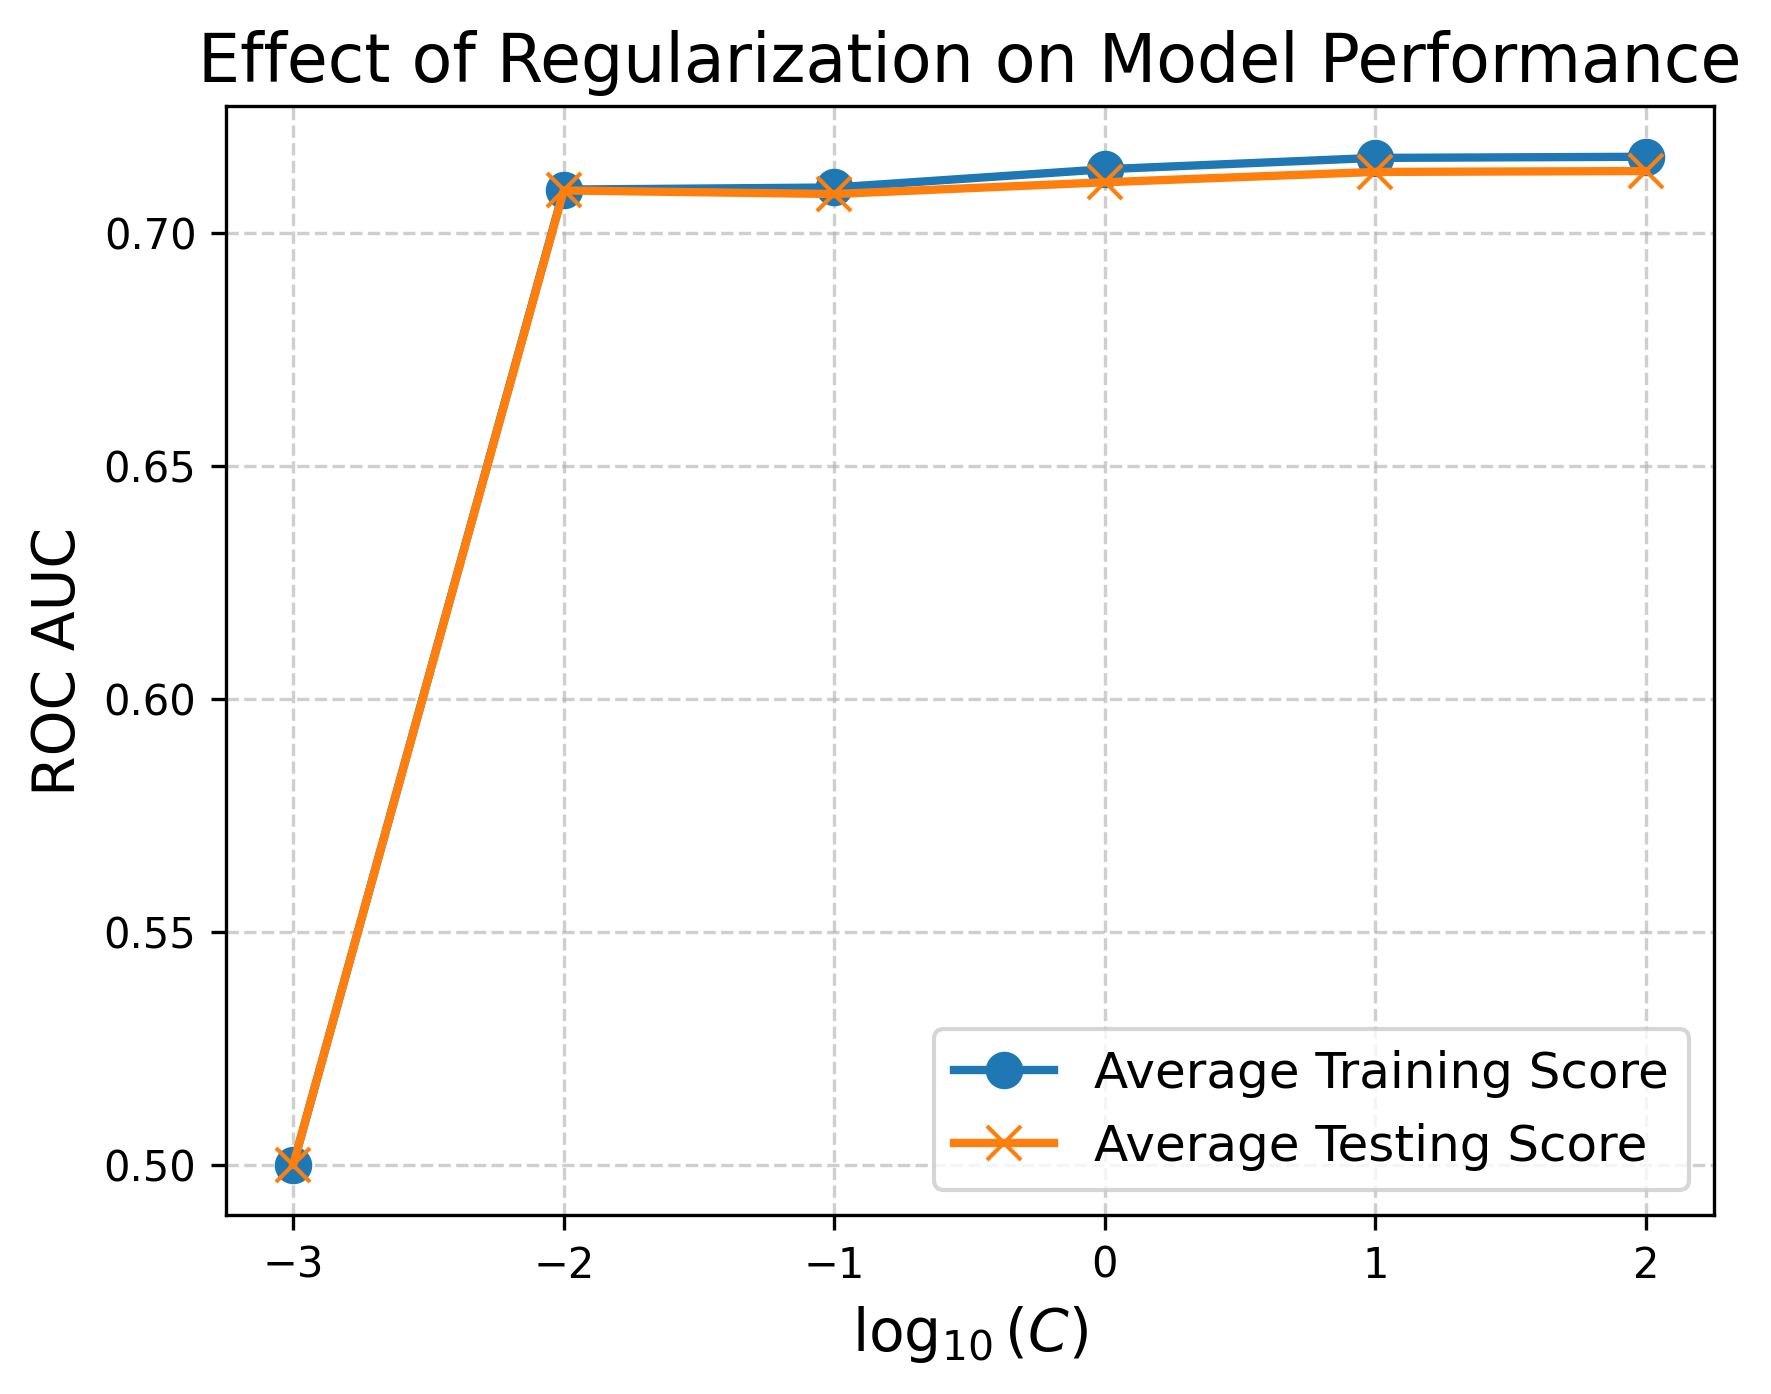

In [ ]:
# Plot training ROC AUC scores
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0),
         '-o', label='Average Training Score', markersize=8, linewidth=2)

# Plot testing ROC AUC scores
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0),
         '-x', label='Average Testing Score', markersize=8, linewidth=2)

plt.xlabel(r'$\log_{10}(C)$', fontsize=14)
plt.ylabel('ROC AUC', fontsize=14)
plt.title('Effect of Regularization on Model Performance', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12);

Regularization offers little benefit here: stronger regularization (lower C) reduces training and test performance. Let's try interaction features to enhance performance.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

make_interactions = PolynomialFeatures(degree=2,
                                       interaction_only=True,
                                       include_bias=False)

# Transform the feature matrix X to include interaction terms
X_interact = make_interactions.fit_transform(X)
X_interact.shape

(26664, 153)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_interact, data_with_education_encoded['default_next_month'].values,
    test_size=0.2, random_state=26)
print(X_train.shape)
print(X_test.shape)

(21331, 153)
(5333, 153)


In [ ]:
%%time
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(
    k_folds, C_vals, min_max_scaler_lr_pipeline, X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C = 100.0


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C = 10.0


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001
CPU times: user 15min 19s, sys: 3.47 s, total: 15min 22s
Wall time: 15min 27s


In [ ]:
np.mean(cv_test_roc_auc, axis=0)

array([0.73662148, 0.73595329, 0.73031942, 0.70914245, 0.70907247,
       0.5       ])

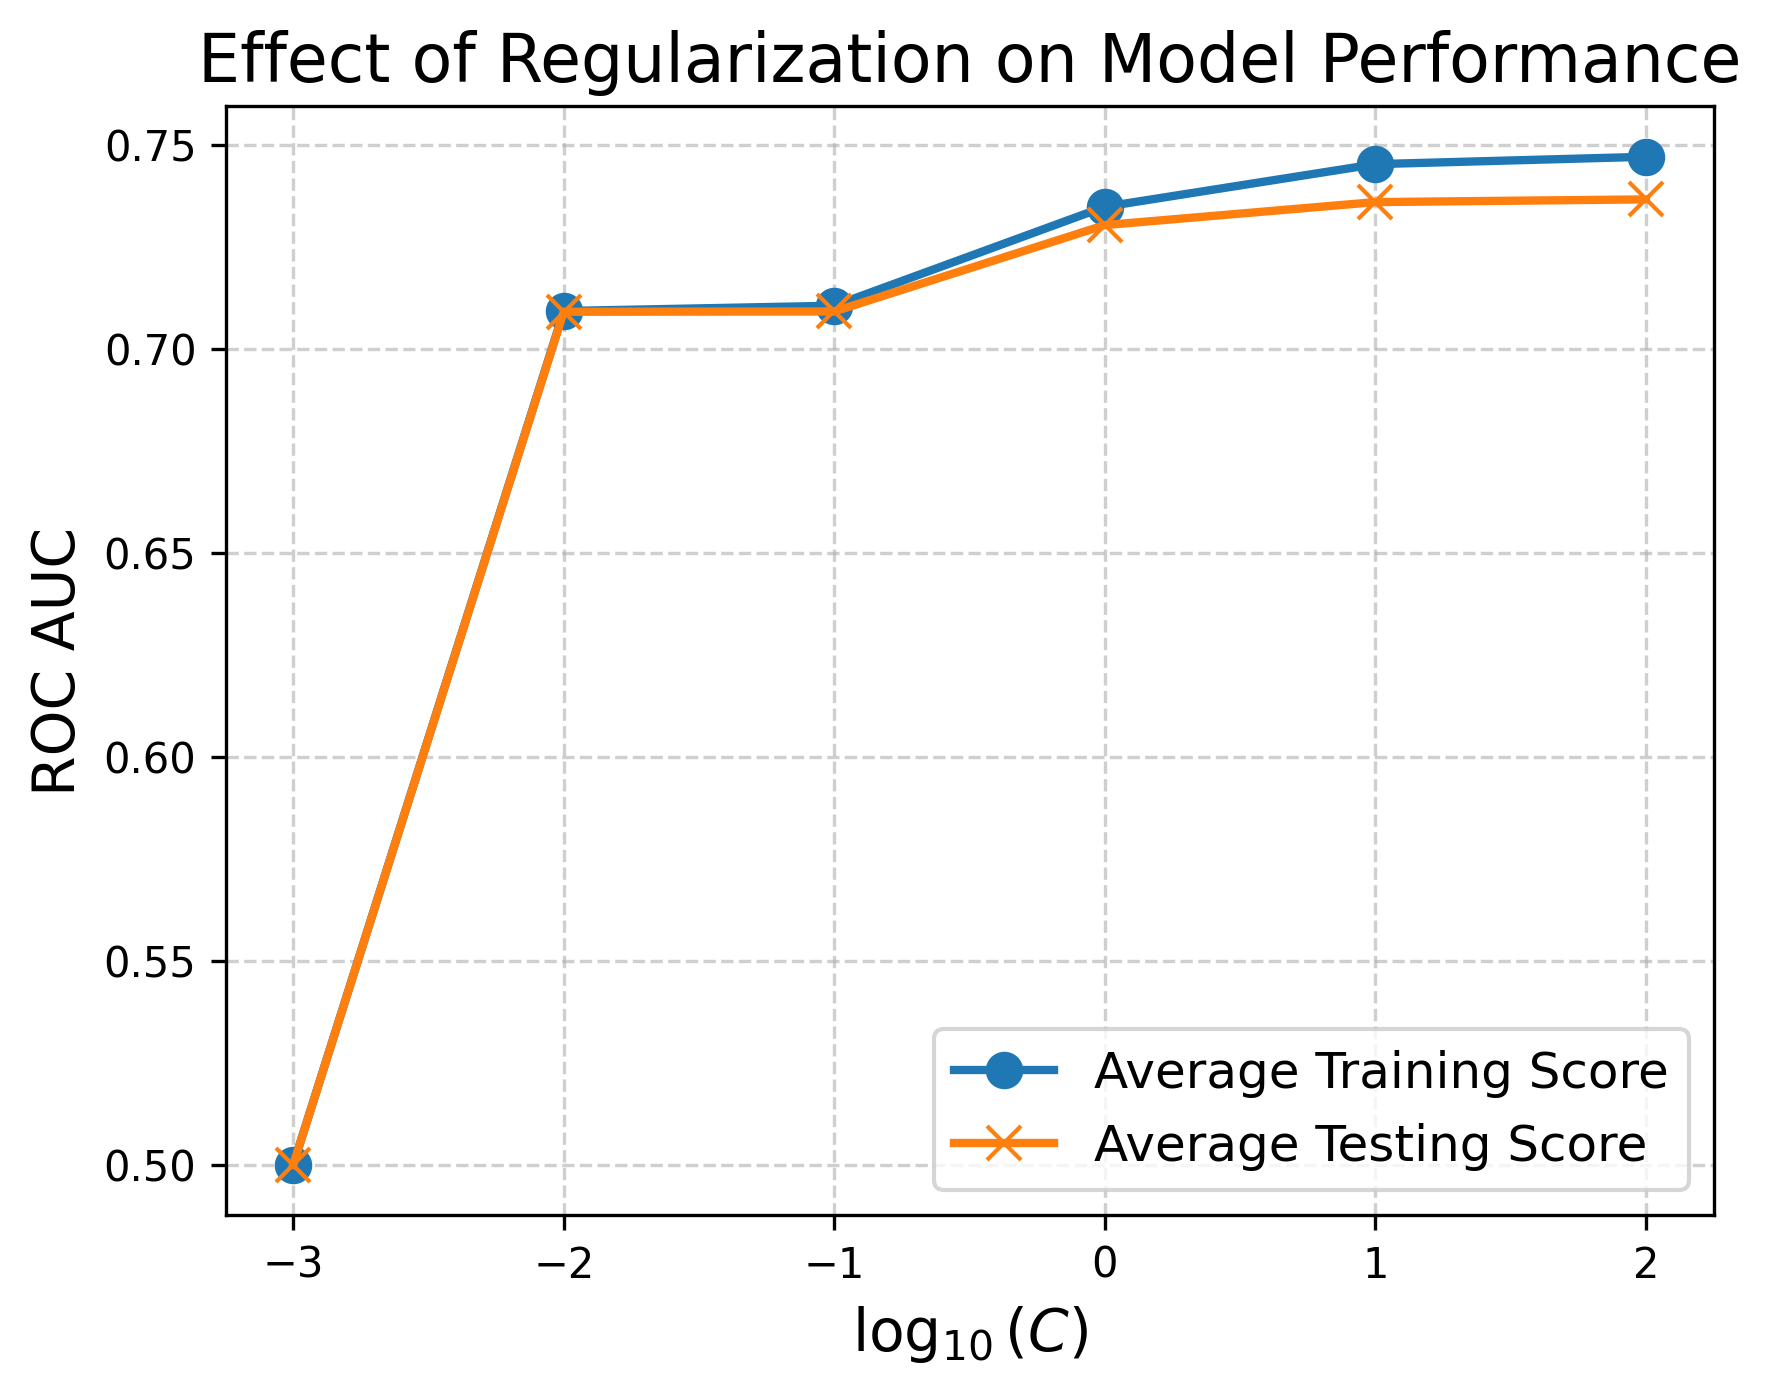

In [ ]:
# Plot training ROC AUC scores
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0),
         '-o', label='Average Training Score', markersize=8, linewidth=2)

# Plot testing ROC AUC scores
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0),
         '-x', label='Average Testing Score', markersize=8, linewidth=2)

plt.xlabel(r'$\log_{10}(C)$', fontsize=14)
plt.ylabel('ROC AUC', fontsize=14)
plt.title('Effect of Regularization on Model Performance', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12);

In [ ]:
np.mean(cv_test_roc_auc, axis=0)

array([0.73662148, 0.73595329, 0.73031942, 0.70914245, 0.70907247,
       0.5       ])

Adding interaction features has only slightly improved cross-validation performance, and regularization is not currently useful with the logistic regression model. We'll postpone fitting the model on the entire training data until after we've tested other models in cross-validation to find the best one.

In [1]:
import graphviz